<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_6b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v6.b) - Visualising broken learning curve
Side-track from v6 focusing on visualising and identifying the cause of learning breakdown within the first 2 epochs of training when training just for ADLO output.

Something just seems weird. Why are we not getting any improvement to performance over time. Why did a different architecture not produce different results.

So let's track down that problem.

As part of this, we'll visualise the activations and gradients to identify the layer with the problem. We'll use the toolkit originally devised from my ml-learning repo:
* https://github.com/malcolmlett/ml-learning/blob/main/Learning_visualisations_v7.ipynb - gradient visualisation
* https://github.com/malcolmlett/ml-learning/blob/main/Learning_visualisations_v8.ipynb - activity visualisation


In [141]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull

# Also checkout ml-learning repo
if os.path.isdir('ml-learning'):
  # discard any local changes and update
  !cd ml-learning && git reset --hard HEAD
  !cd ml-learning && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git ml-learning
#!cd ml-learning && git checkout c4f0bfe
!cd ml-learning && git pull

import sys
sys.path.append('repo')
sys.path.append('ml-learning')

from general_utils import display_history
import lds
import slam_models
import slam_data
import slam_operations
import toolkit
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_data)
reload(slam_operations)
reload(toolkit)

HEAD is now at 2d44993 Added gradient and unit activation visualisations to help locate cause of problems
Already up to date.
HEAD is now at 820c980 Colored text
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.57 KiB | 802.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   820c980..9a71dbf  main       -> origin/main
Updating 820c980..9a71dbf
Fast-forward
 toolkit.py | 456 ++++++++++++++++++++++++++++++++++++++++++++++-----------------------------------
 1 file changed, 257 insertions(+), 199 deletions(-)


<module 'toolkit' from '/content/ml-learning/toolkit.py'>

In [107]:
# Load standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as idisplay
import os
import sys
import math
import tqdm
import time
from timeit import default_timer as timer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [108]:
# Training data
# - use model-derived training data to emulate the end of the real training loop
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2.png')

# Load training data
if os.path.isfile('custom-training-data.npz'):
  train_data = slam_data.load_dataset('custom-training-data.npz')
else:
  print(f"Sorry, pre-generated dataset not available, you'll need to generate it.")

  # Load pre-trained model
  raw_model = tf.keras.models.load_model('slam-model-300epochs.keras')

  # generate data
  np.random.seed(0)  # for consistency
  train_data = slam_data.generate_training_data(floorplan, 1000, model=raw_model)
  slam_data.validate_dataset(train_data)

  # save
  slam_data.save_dataset(train_data, 'custom-training-data.npz')

Loaded:
  input_maps:  (1000, 149, 149, 3) x float32
  lds_maps:    (1000, 149, 149) x float32
  output_maps: (1000, 149, 149, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from custom-training-data.npz


## Local tools


In [109]:
def show_adlo_predictions(model, dataset, num=5, **kwargs):
    sample_types = kwargs.get('sample_types', None)
    display_type = kwargs.get('display_type', 'plot')  # one of: plot, list

    ds = slam_data.filter_dataset(dataset, num, sample_types)
    inputs, outputs, metadatas = next(iter(dataset.batch(num)))
    preds = model.predict(inputs)

    if display_type == 'plot':
      for map_window, lds_map, ground_truth_map, adlo, metadata, adlo_pred in zip(
              inputs[0], inputs[1], outputs[0], outputs[1], metadatas, preds):
          map_pred = None
          show_adlo_prediction(map_window, lds_map, ground_truth_map, adlo, metadata, map_pred, adlo_pred, **kwargs)
    elif display_type == 'list':
      data = []
      for map_window, lds_map, ground_truth_map, adlo, metadata, adlo_pred in zip(
              inputs[0], inputs[1], outputs[0], outputs[1], metadatas, preds):
          map_pred = None
          adlo_pred_scaled = scale_adlo_prediction(map_window, lds_map, ground_truth_map, adlo, metadata, map_pred, adlo_pred, **kwargs)
          data.append([
              metadata[1].numpy(),  # sample type
              adlo[0].numpy(), adlo_pred[0],  # accept
              adlo[1].numpy(), adlo_pred[1],  # delta x
              adlo[2].numpy(), adlo_pred[2],  # delta y
              adlo[3].numpy(), adlo_pred[3],  # delta orientation
          ])
      columns = ['type', 'accept', 'accept_pred', 'delta_x', 'delta_x_pred', 'delta_y', 'delta_y_pred', 'delta_orientation', 'delta_orientation_pred']
      df = pd.DataFrame(data, columns=columns)
      display(df)
    else:
      raise ValueError(f"Unknown display type: {display_type}")

def scale_adlo_prediction(input_map, lds_map, map_true, adlo, metadata, map_pred, adlo_pred, **kwargs):
    from_logits = kwargs.get('from_logits', True)

    # apply scaling
    if adlo_pred is not None:
        accept = tf.nn.sigmoid(adlo_pred[0]) if from_logits else adlo_pred[0]
        adlo_pred_scaled = tf.stack([accept, adlo_pred[1], adlo_pred[2], adlo_pred[3]], axis=0)
    else:
        adlo_pred_scaled = None

    return adlo_pred_scaled

def show_adlo_prediction(input_map, lds_map, map_true, adlo, metadata, map_pred, adlo_pred, **kwargs):
    """
    :param input_map:
    :param lds_map:
    :param map_true:
    :param adlo:
    :param metadata:
    :param map_pred:
    :param adlo_pred:

    Keyword args:
      show_classes: one of 'none' (or False), 'all' (or True), 'pred'
    """
    from_logits = kwargs.get('from_logits', True)
    show_classes = kwargs.get('show_classes', 'none')
    map_size = np.array([input_map.shape[1], input_map.shape[0]])
    n_classes = input_map.shape[-1]

    # apply scaling
    if adlo_pred is not None:
        accept = tf.nn.sigmoid(adlo_pred[0]) if from_logits else adlo_pred[0]
        adlo_pred_scaled = tf.stack([accept, adlo_pred[1], adlo_pred[2], adlo_pred[3]], axis=0)
    else:
        adlo_pred_scaled = None

    # Log details that are not so great in visual form
    print(f"adlo-true: {adlo}")
    print(f"adlo-pred: {adlo_pred_scaled}")
    print(f"metadata:  {metadata}")

    # Calculate total number of plots to display
    cols = 0
    cols = cols + (1 if input_map is not None else 0)
    cols = cols + (1 if lds_map is not None else 0)
    cols = cols + (1 if map_true is not None else 0)

    # Show plots
    plt.figure(figsize=(10, 2))  # limits by row height
    i = iter(range(1, cols+1))

    if input_map is not None:
        plt.subplot(1, cols, next(i))
        plt.title('Map')
        plt.imshow(input_map)
        plt.axis('off')
        if adlo is not None and not adlo[0]:
            # to be rejected so just add cross through map
            plt.plot([0, map_size[0] - 1], [0, map_size[1] - 1], c='y')
            plt.plot([0, map_size[0] - 1], [map_size[1] - 1, 0], c='y')
        elif adlo is not None:
            # show adlo relative to centre dot
            centre = map_size / 2
            error_loc = centre + adlo[1:3] * map_size
            angle_loc = error_loc + np.array([np.cos(adlo[3] * np.pi), np.sin(adlo[3] * np.pi)]) * 50
            plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
            plt.scatter(centre[0], centre[1], c='k', s=50)
            plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

    if lds_map is not None:
        plt.subplot(1, cols, next(i))
        plt.title('LDS')
        plt.imshow(lds_map, cmap='gray')
        plt.axis('off')

    if map_true is not None:
        plt.subplot(1, cols, next(i))
        plt.title('Ground Truth')
        plt.imshow(map_true)
        plt.axis('off')
        if adlo_pred_scaled is not None:
            centre = map_size / 2
            error_loc = centre + adlo_pred_scaled[1:3] * map_size
            angle = adlo_pred_scaled[3] * np.pi
            angle_loc = error_loc + np.array([np.cos(angle), np.sin(angle)]) * 50
            plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
            plt.scatter(centre[0], centre[1], c='k', s=50)
            plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

    plt.show()

def plot_weights(model, all_layers=False):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  if all_layers:
    plots_tot = L+1
  else:
    plots_tot = 1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained', figsize=(20,20))

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  if all_layers:
    for l in range(L):
      variables = []
      for weight in model.layers[l].weights:
        variables = np.append(variables, weight.numpy().flatten())
      plt.subplot(plots_rows, plots_cols, l+2)
      plt.title(f"layer {l}:\n{model.layers[l].name}")
      plt.hist(variables)
      plt.xlabel("value")
      plt.ylabel("histogram count")
  plt.show()

def plot_conv_layer_values(values):
  global_min = tf.reduce_min(values).numpy()
  global_max = tf.reduce_max(values).numpy()
  inp_to_outp_min = tf.reduce_min(values, axis=(0,1))
  inp_to_outp_mean = tf.reduce_mean(values, axis=(0,1))
  inp_to_outp_max = tf.reduce_max(values, axis=(0,1))
  plot_aspect = inp_to_outp_mean.shape[1] / inp_to_outp_mean.shape[0]
  kernel_min = tf.reduce_min(values, axis=(2,3))
  kernel_mean = tf.reduce_mean(values, axis=(2,3))
  kernel_max = tf.reduce_max(values, axis=(2,3))

  plt.figure(figsize=(15,10))

  plt.subplot(2,3,1)
  plt.title(f"min:{w.numpy().shape} --> {inp_to_outp_min.numpy().shape}")
  plt.xlabel("output channels")
  plt.ylabel("input channels")
  plt.imshow(inp_to_outp_min, aspect=plot_aspect, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.subplot(2,3,2)
  plt.title(f"mean:{w.numpy().shape} --> {inp_to_outp_mean.numpy().shape}")
  plt.xlabel("output channels")
  plt.ylabel("input channels")
  plt.imshow(inp_to_outp_mean, aspect=plot_aspect, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.subplot(2,3,3)
  plt.title(f"max:{w.numpy().shape} --> {inp_to_outp_max.numpy().shape}")
  plt.xlabel("output channels")
  plt.ylabel("input channels")
  plt.imshow(inp_to_outp_max, aspect=plot_aspect, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.subplot(2,3,4)
  plt.title(f"min:{w.numpy().shape} --> {kernel_min.numpy().shape}")
  plt.imshow(kernel_min, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.subplot(2,3,5)
  plt.title(f"mean:{w.numpy().shape} --> {kernel_mean.numpy().shape}")
  plt.imshow(kernel_mean, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.subplot(2,3,6)
  plt.title(f"max:{w.numpy().shape} --> {kernel_max.numpy().shape}")
  plt.imshow(kernel_max, vmin=global_min, vmax=global_max)
  plt.colorbar()

  plt.show()

## Simplified Model
ADLO Output only model.

In [110]:
def adlo_model(map_shape, conv_filters=32, adlo_units=256, **kwargs):
    merge_mode = kwargs.get('merge_mode', 'concat')
    output_logits = kwargs.get('output_logits', True)
    do_compile = kwargs.get('compile', False)
    dlo_encoding = kwargs.get('dlo_encoding', 'linear/importance')

    # Sanity check
    if np.size(map_shape) != 3:
        raise ValueError(f"Map shape must have 3 dims, found {np.size(map_shape)}")

    # Prepare map input
    # (pad so it's a multiple of our down/up-scaling blocks)
    map_input = Input(shape=map_shape, name='map_input')
    map_down, pad_w, pad_h = slam_models.pad_block(map_input, map_shape)
    n_classes = map_shape[2]

    # Prepare LDS input
    # (convert from (B,H,W) to (B,H,W,1) to make later work easier)
    # (pad so it's a multiple of our down/up-scaling blocks)
    lds_shape = (map_shape[0], map_shape[1], 1)
    lds_input = Input(shape=(map_shape[0], map_shape[1]), name='lds_input')  # raw input omits channels axis
    lds_down = tf.keras.layers.Reshape(target_shape=lds_shape)(lds_input)
    lds_down, _, _ = slam_models.pad_block(lds_down, lds_shape)

    # Map downsampling input arm
    # (each block here returns two outputs (downsampled, convolved-only),
    #  the latter is used for skip-connections)
    map_down, map_skip1 = slam_models.slam_down_block(map_down, conv_filters)
    map_down, map_skip2 = slam_models.slam_down_block(map_down, conv_filters * 2)
    map_down, map_skip3 = slam_models.slam_down_block(map_down, conv_filters * 4)
    map_down, map_skip4 = slam_models.slam_down_block(map_down, conv_filters * 8, dropout_prob=0.3)

    # LDS downsampling input arm
    lds_down, lds_skip1 = slam_models.slam_down_block(lds_down, conv_filters)
    lds_down, lds_skip2 = slam_models.slam_down_block(lds_down, conv_filters * 2)
    lds_down, lds_skip3 = slam_models.slam_down_block(lds_down, conv_filters * 4)
    lds_down, lds_skip4 = slam_models.slam_down_block(lds_down, conv_filters * 8, dropout_prob=0.3)

    # Bottom layer
    # (combine both input arms, apply some final convolutions, leave at same scale)
    bottom = Concatenate(axis=3)([map_down, lds_down])
    #bottom, _ = slam_models.slam_down_block(bottom, conv_filters * 16, max_pooling=False)
    #bottom, _ = slam_models.slam_down_block(bottom, conv_filters * 16, max_pooling=False)
    bottom, _ = slam_models.slam_down_block(bottom, conv_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Accept and Delta location/orientation output
    adlo_out = slam_models.adlo_block(bottom, adlo_units, output_logits, dlo_encoding)

    model = tf.keras.Model(inputs=[map_input, lds_input], outputs=[adlo_out])

    if do_compile:
        loss = (
            slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding)
        )
        metrics = {
            'adlo_output': [slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding),
                            slam_models.AcceptAccuracy(),
                            slam_models.LocationError(),
                            slam_models.OrientationError()]
        }
        model.compile(optimizer='adam', loss=loss, metrics=metrics)

    print(f"Prepared SLAM model")
    print(f"  Map shape:        {map_shape} + padding ({pad_h}, {pad_w}, 0)")
    print(f"  Skip-connections: {merge_mode}")
    print(f"  Output scaling:   {'logits' if output_logits else 'scaled'}")
    print(f"  DLO encoding:     {dlo_encoding}")
    print(f"  Layers:           {len(model.layers)}")
    print(f"  Inputs:           {model.inputs}")
    print(f"  Outputs:          {model.outputs}")
    print(f"  Output names:     {model.output_names}")
    print(f"  Compiled:         {do_compile}")
    return model

def for_adlo_training(inputs, outputs, metadata):
    (map_input, lds_input), (map_output, adlo_output) = inputs, outputs
    return (map_input, lds_input), adlo_output

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_311>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accept_accuracy: 0.6723 - adlo_loss: 5.9235 - loc_error: 0.2344 - loss: 5.9253 - orientation_error: 1.6314
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accept_accuracy: 0.7467 - adlo_loss: 1.2332 - loc_error: 0.1021 - loss: 1.2334 - orientation_error: 0.1793
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accept_accuracy: 0.7480 - adlo_loss: 1.2610 - loc_error: 0.1121 -

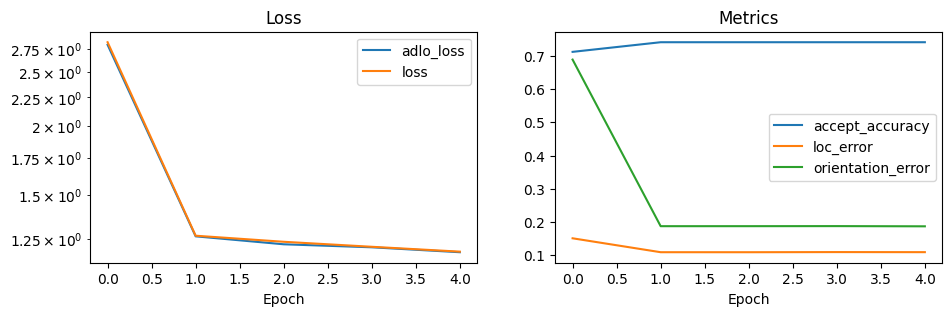

In [111]:
# Train model
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 5
batch_size = 32
tf.config.run_functions_eagerly(True)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, verbose_history=True)

start = timer()
model_history = tf.keras.callbacks.History()
model.fit(model_train_data, epochs=epochs, callbacks=[model_history])
duration = (timer() - start)

print(f"Total epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lds_input (InputLayer)    │ (None, 149, 149)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 149, 149, 1)    │              0 │ lds_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 160, 160, 1)    │              0 │ reshape[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 32)   │            896 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 160, 160, 32)   │            320 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 160, 160, 32)   │          9,248 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 80, 80, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 80, 80, 64)     │         36,928 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 40, 40, 64)     │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)       

 Total params: 22,841,918 (87.14 MB)

 Trainable params: 7,613,972 (29.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,227,946 (58.09 MB)

In [9]:
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

for inputs, outputs in model_train_data.take(1):
    print(f"map_input: {inputs[0].shape}, lds_input: {inputs[0].shape}, adlo_output: {outputs.shape}")
    print(outputs)

map_input: (32, 149, 149, 3), lds_input: (32, 149, 149, 3), adlo_output: (32, 4)
tf.Tensor(
[[ 1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.         -0.03305578  0.1854545  -0.6406362 ]
 [ 1.         -0.02173826  0.08087041  0.04976431]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.         -0.42646164 -0.38330922  0.5640158 ]
 [ 1.         -0.3123356   0.25098598  0.9672273 ]
 [ 0.          0.          0.          0.        ]
 [ 1.         -0.12942822  0.29332703  0.99499017]
 [ 1.         -0.03855803  0.02012942  0.00909979]
 [ 1.          0.05968145  0.01100972  0.06654791]
 [ 1.          0.01614685  0.08664806  0.48382065]
 [ 1.         -0.0944361  -0.01841013  0.00768794]
 [ 1.         -0.42300192  0.10271972 -0.882111  ]
 [ 1.         -0.46405402 -0.02127839 -0.67647374]
 [ 1.         -0.24422163 -0.09526814  0.7208076 ]
 [ 1.          0.03346982  0.09646053  0.

In [10]:
# Let's look at the model predictions
show_adlo_predictions(model, train_data, num=10, display_type='list')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


type  accept  accept_pred   delta_x  delta_x_pred   delta_y  delta_y_pred  \
0   0.0     1.0     0.981082  0.000000     -0.001164  0.000000      0.000506   
1   3.0     0.0     0.981082  0.000000     -0.001164  0.000000      0.000506   
2   2.0     1.0     0.981082 -0.494130     -0.001164 -0.206749      0.000506   
3   1.0     1.0     0.981082 -0.032534     -0.001164 -0.002947      0.000506   
4   2.0     1.0     0.981082  0.274840     -0.001164 -0.128493      0.000506   
5   3.0     0.0     0.981082  0.000000     -0.001164  0.000000      0.000506   
6   1.0     1.0     0.981082 -0.022084     -0.001164  0.030389      0.000506   
7   2.0     1.0     0.981082 -0.225254     -0.001164  0.444011      0.000506   
8   1.0     1.0     0.981082 -0.040690     -0.001164 -0.061804      0.000506   
9   2.0     1.0     0.981082  0.388187     -0.001164 -0.212914      0.000506   

   delta_orientation  delta_orientation_pred  
0           0.000000                0.018126  
1           0.000000                0.018126  
2          -0.944113                0.018126  
3           0.050610                0.018126  
4           0.629031                0.018126  
5           0.000000                0.018126  
6           0.078957                0.018126  
7          -0.485207                0.018126  
8           0.018774                0.018126  
9           0.628041                0.018126

## Using training visualisations

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_350>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True
Epoch 1/5
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:57 6s/step - accept_accuracy: 0.3750 - adlo_loss: 3.3321 - loc_error: 0.1706 - loss: 3.3321 - orientation_error: 0.6710

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accept_accuracy: 0.5907 - adlo_loss: 5.3786 - loc_error: 0.2768 - loss: 2.6037 - orientation_error: 1.2929
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accept_accuracy: 0.7480 - adlo_loss: 1.2676 - loc_error: 0.1127 - loss: 1.2191 - orientation_error: 0.1972
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accept_accuracy: 0.7595 - adlo_loss: 1.2095 - loc_error: 0.1085 - loss: 1.2002 - orientation_error: 0.1812
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 327ms/step - accept_accuracy: 0.7340 - adlo_loss: 1.2168 - loc_error: 0.1088 - loss: 1.1970 - orientation_error: 0.1802
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accept_accuracy: 0.7333 - adlo_loss: 1.2155 - loc_error: 0.1082 - loss: 1.1933 - orientation_error: 0.1803


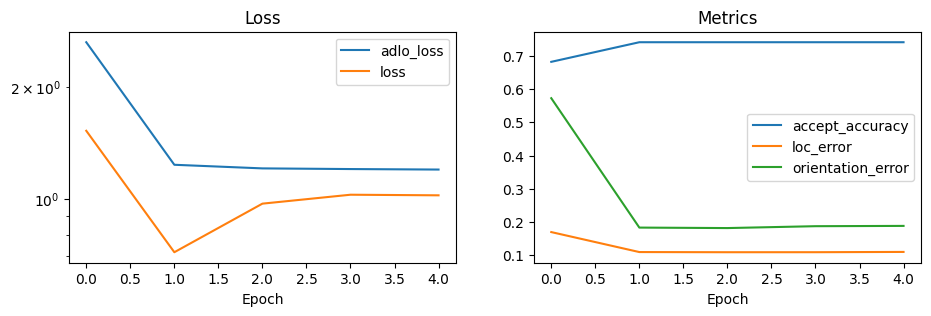

In [112]:
# Let's re-train with training visualisations enabled
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 5
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, verbose_history=True)

activity = toolkit.ActivityRateCallback(model_train_data, interval=1)
gradients = toolkit.GradientHistoryCallback()
model_history = toolkit.fit(model, model_train_data, epochs=epochs, gradient_callback=gradients, callbacks=[activity])

display_history(model_history)

In [115]:
# Check layer numbers and names
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lds_input (InputLayer)    │ (None, 149, 149)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 149, 149, 1)    │              0 │ lds_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_16         │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_17         │ (None, 160, 160, 1)    │              0 │ reshape_8[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 160, 160, 32)   │            896 │ zero_padding2d_16[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_160 (Conv2D)       │ (None, 160, 160, 32)   │            320 │ zero_padding2d_17[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_152[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_161 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_160[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_64          │ (None, 80, 80, 32)     │              0 │ conv2d_153[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_68          │ (None, 80, 80, 32)     │              0 │ conv2d_161[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_64[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_162 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_68[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_155 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_154[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_163 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_162[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_65          │ (None, 40, 40, 64)     │              0 │ conv2d_155[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_69          │ (None, 40, 40, 64)     │              0 │ conv2d_163[0][0]       │
│ (MaxPooling2D)       

 Total params: 22,841,918 (87.14 MB)

 Trainable params: 7,613,972 (29.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,227,946 (58.09 MB)

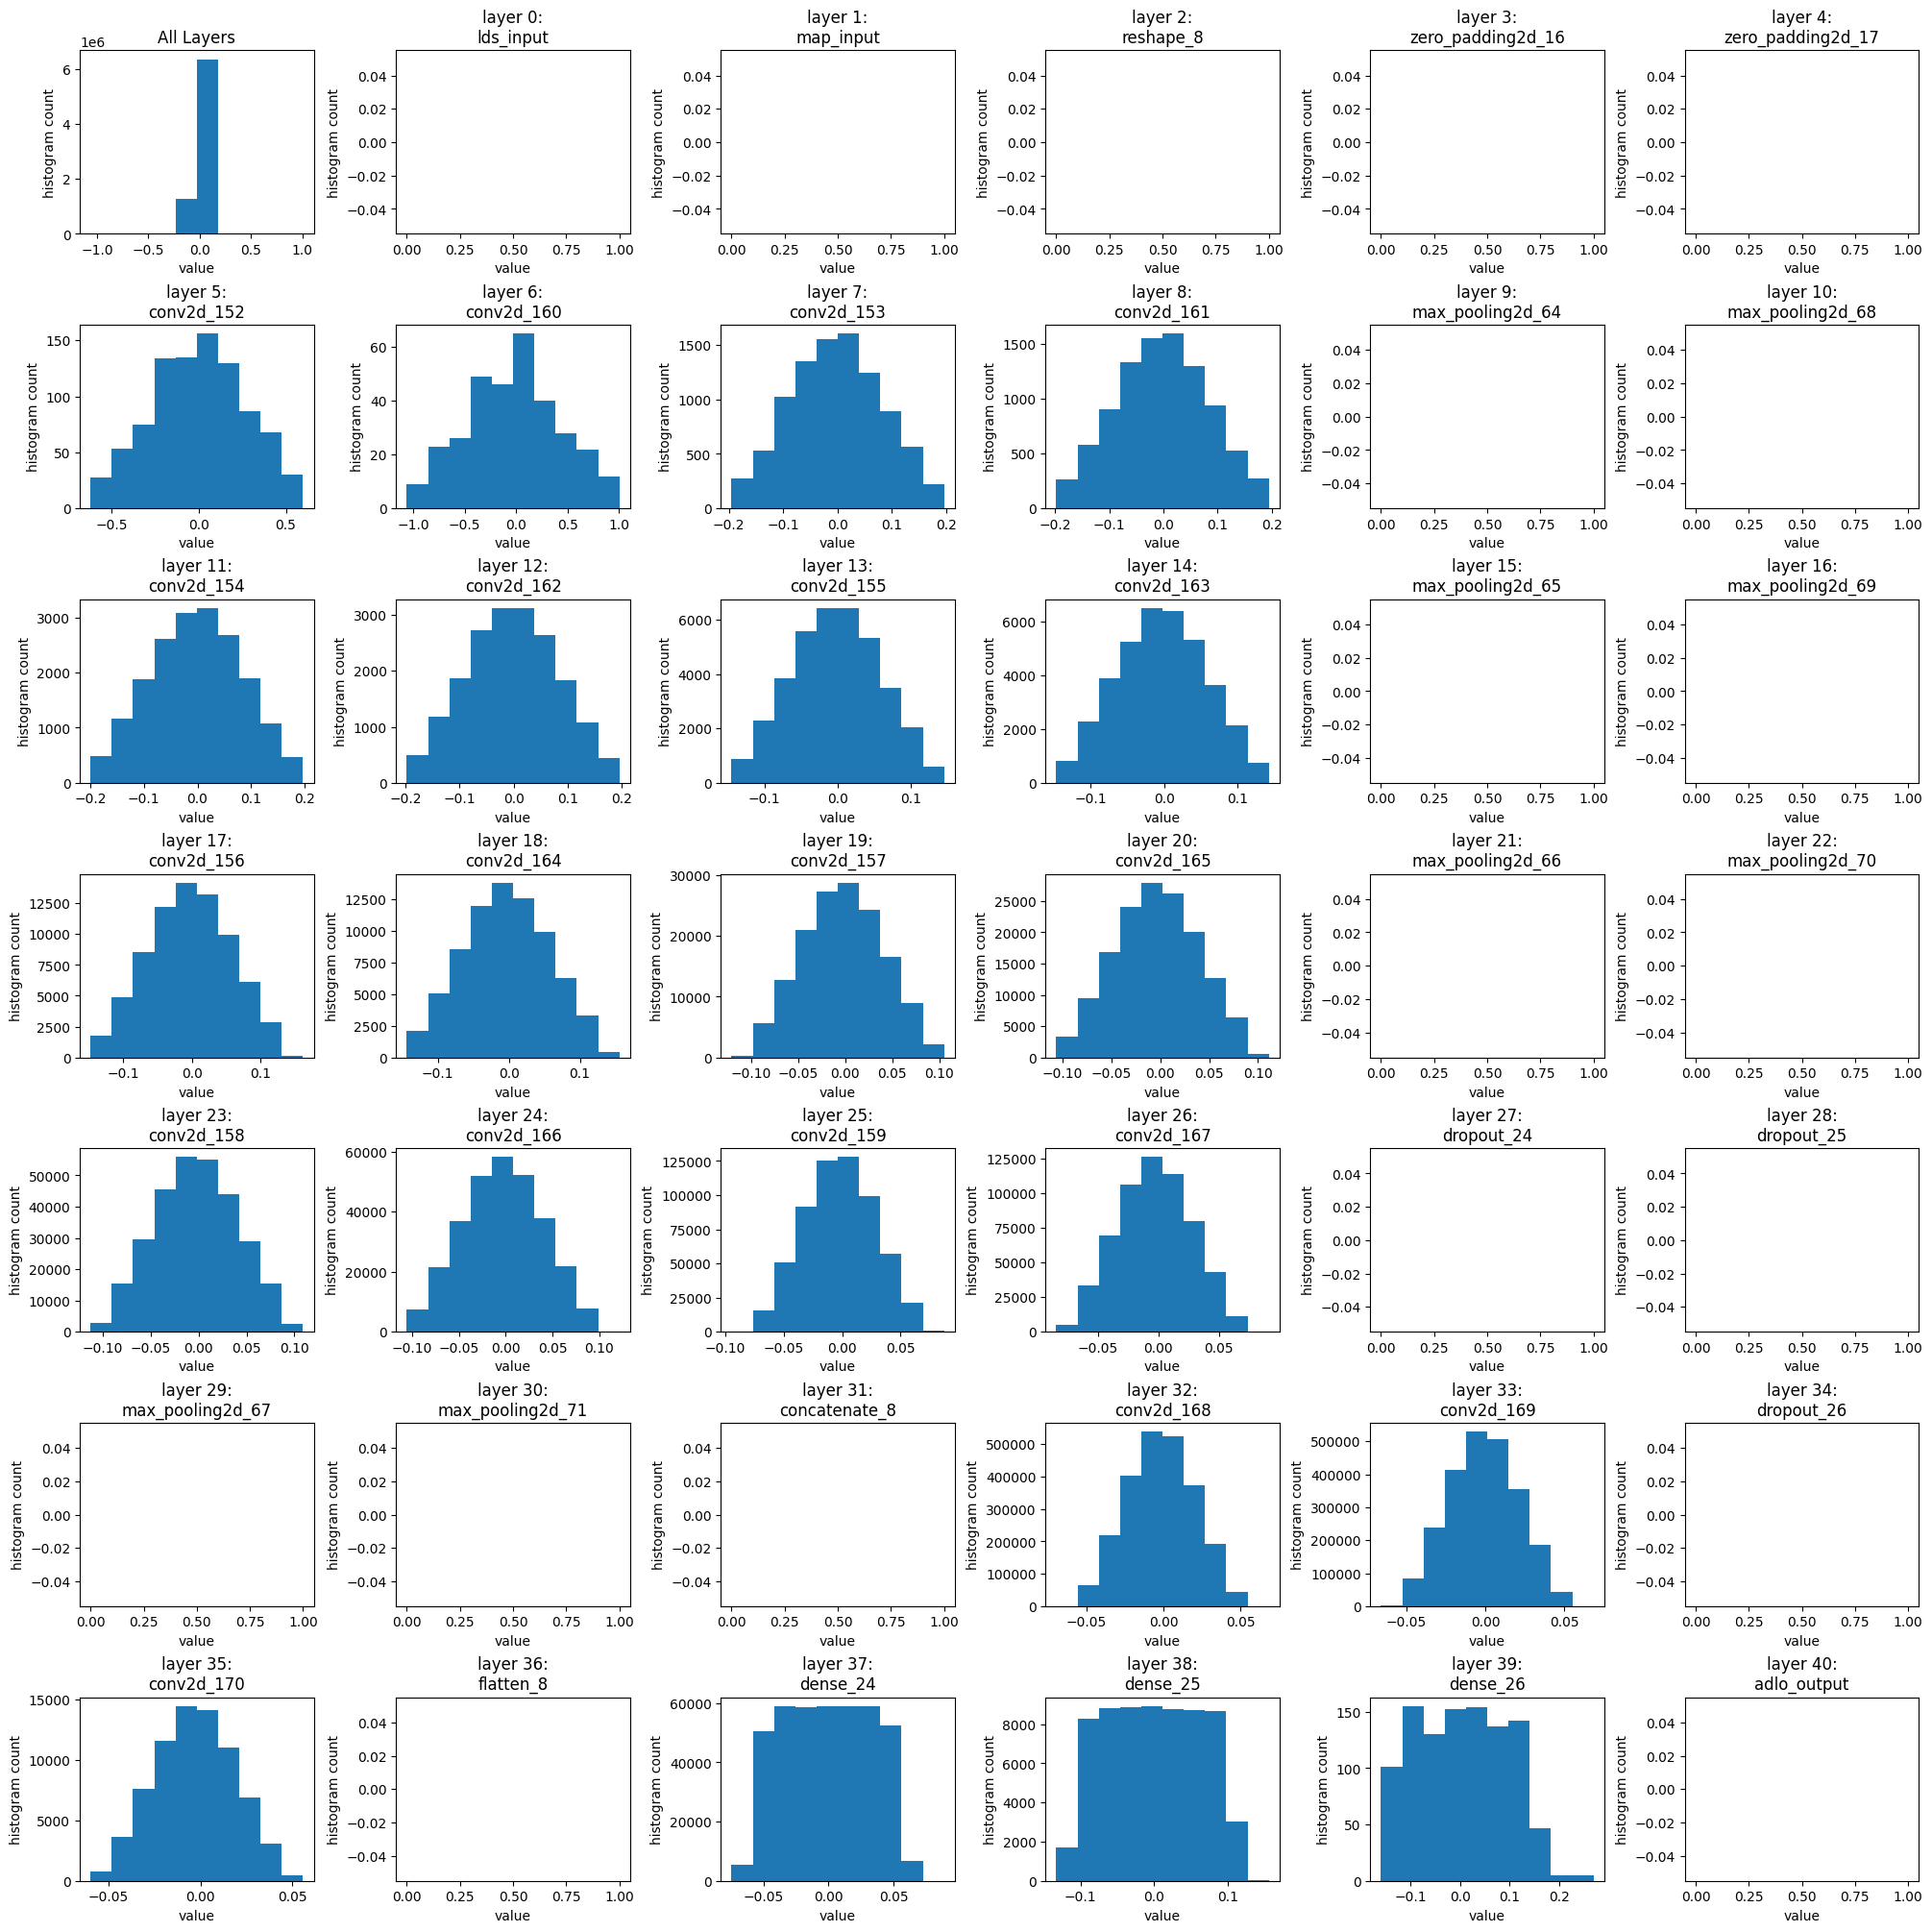

In [142]:
# What do the trained model weights looked like?
plot_weights(model, all_layers=True)

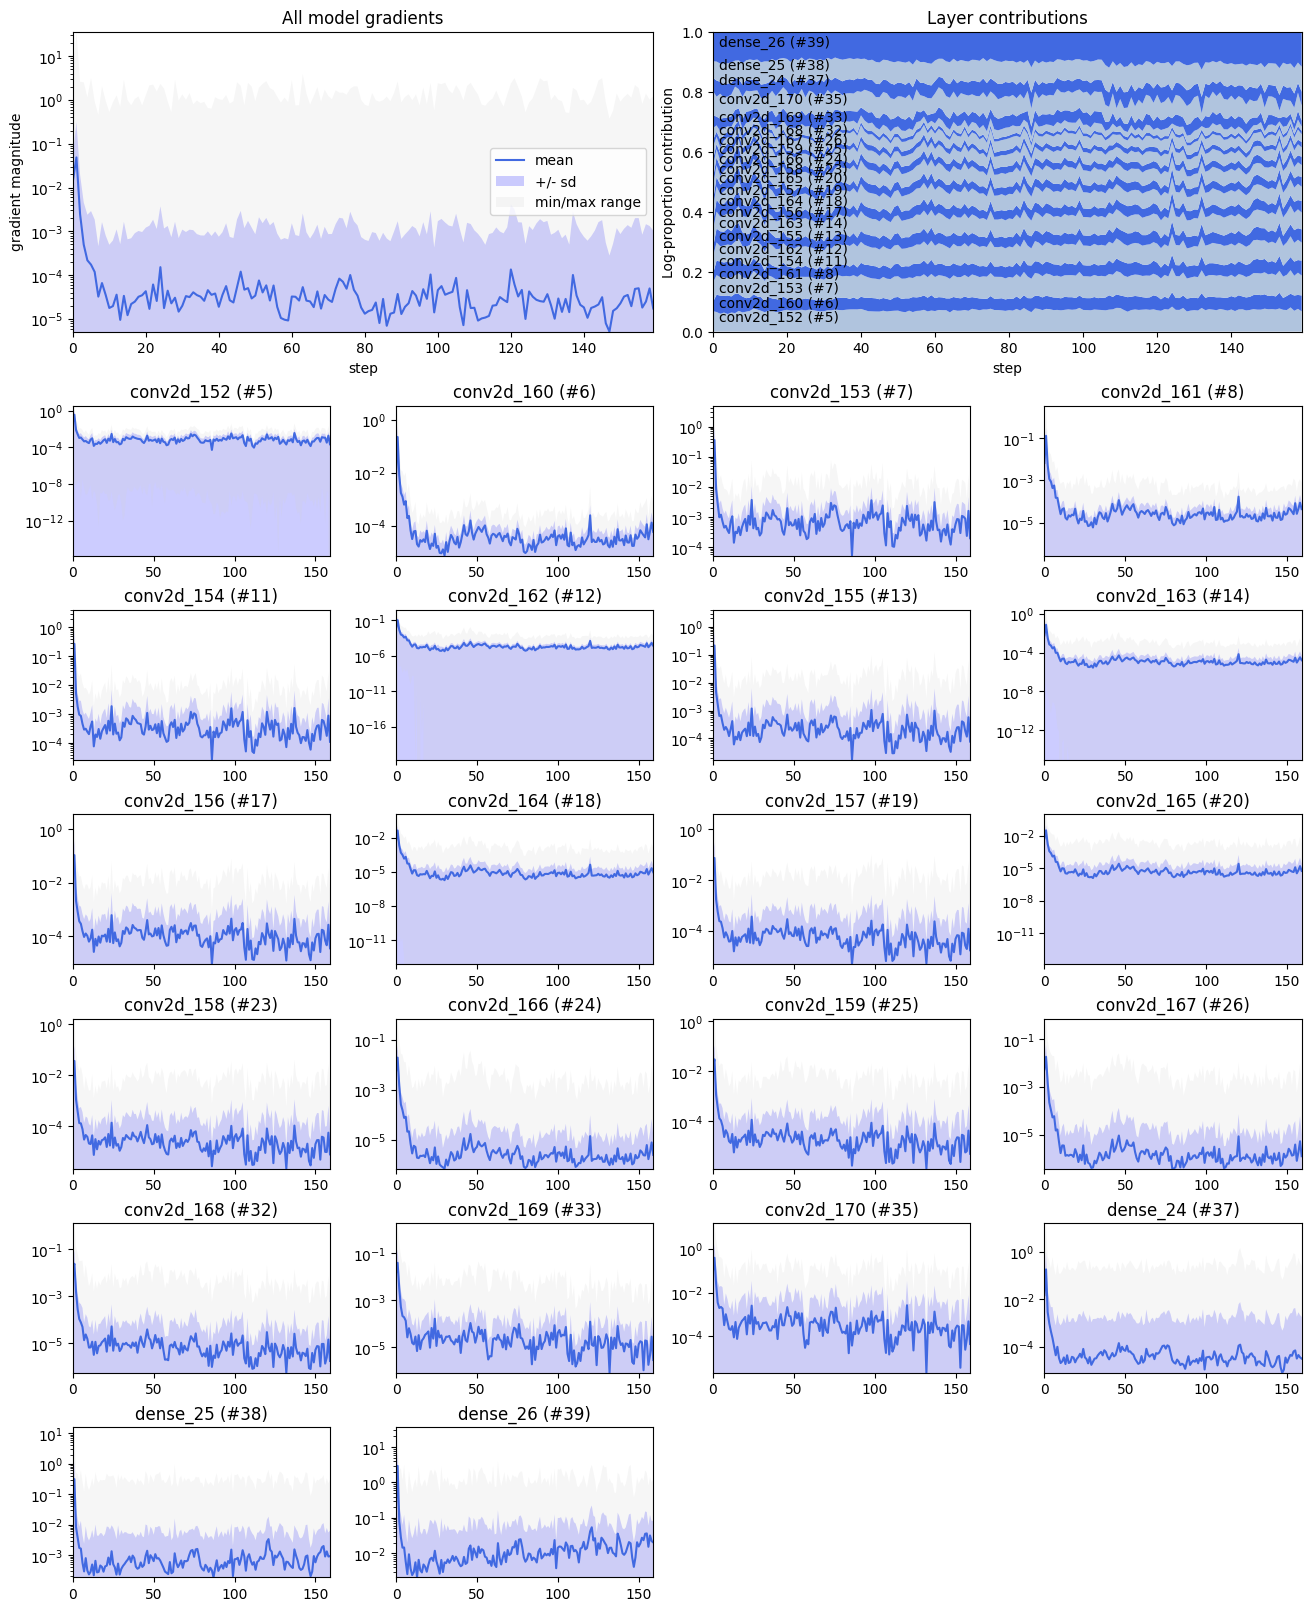

In [113]:
# gradients during above training
gradients.plot_summary()

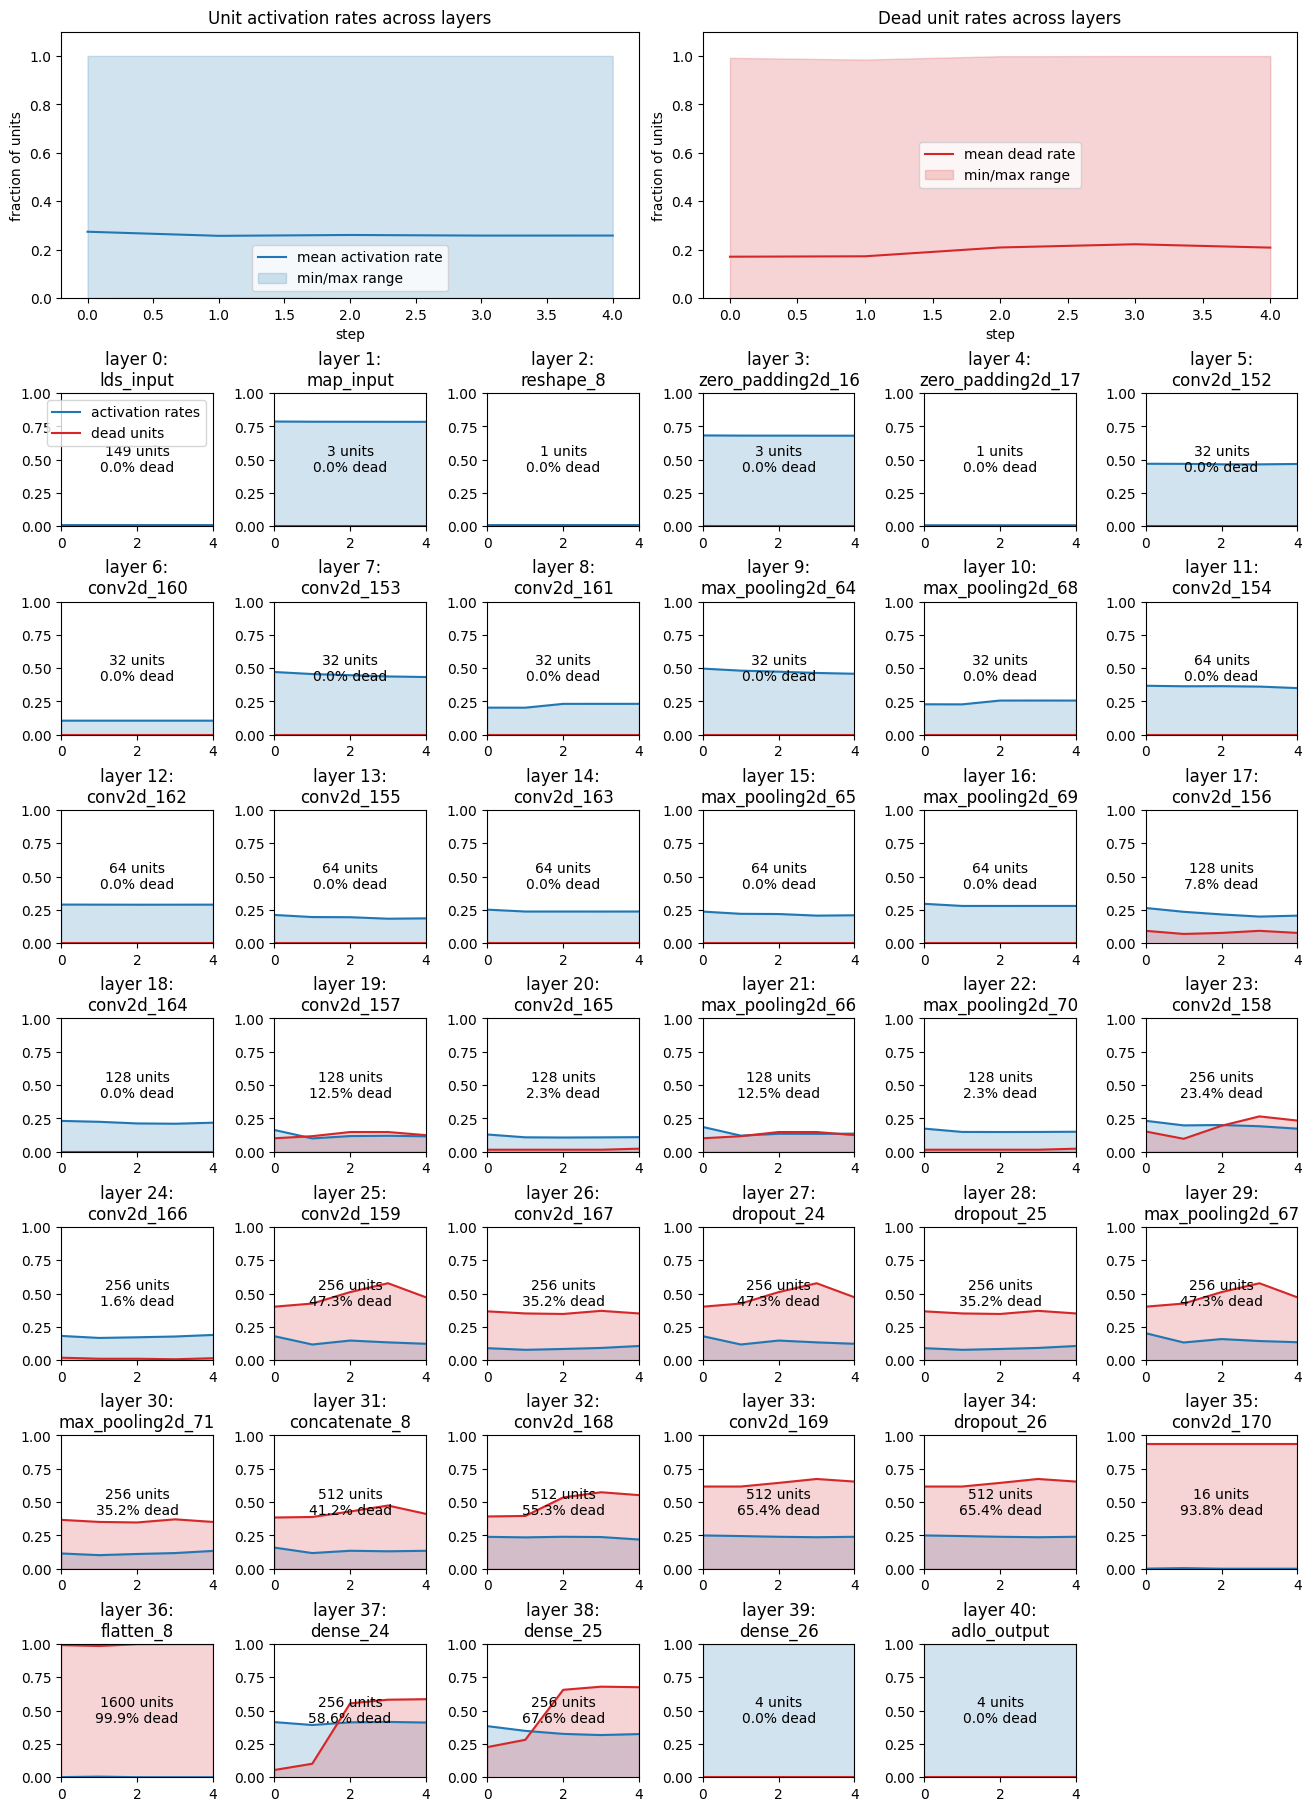

In [143]:
# unit activity rates during above training
# Note:
#  All layers are assumed to produce outputs with shapes of form: `(batch_size, ..spatial_dims.., channels)`.
#  Unit activation rates are recorded per-channel, aggregated across batch and spatial dims, and then stats collected
#  across the channels.
#  In other words, each physical unit with its unique set of weights is treated as a single atomic component
#  that is re-used multiple times across batch and spatial dims. Stats are then collected against that atomic
#  component in terms of how often it is active (non-zero output) vs inactive (zero output).

#activity.plot_summary()

toolkit.plot_unit_activity(activity)

In [117]:
# and spatial activations after training
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = toolkit.measure_unit_activity(model, model_train_data, include_channel_activity=True, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")

100%|██████████| 32/32 [00:04<00:00,  6.93it/s]

model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.999375, 'mean_dead_rate': 0.20901676829268295, 'min_activation_rate': 0.0006249999, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.2588404}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.009234081}, {'dead_rate': 0.0, 'activation_rate': 0.7860921}, {'dead_rate': 0.0, 'activation_rate': 0.009234081}, {'dead_rate': 0.0, 'activation_rate': 0.68171984}, {'dead_rate': 0.0, 'activation_rate': 0.008008041}, {'dead_rate': 0.0, 'activation_rate': 0.46813703}, {'dead_rate': 0.0, 'activation_rate': 0.10612348}, {'dead_rate': 0.0, 'activation_rate': 0.43334532}, {'dead_rate': 0.0, 'activation_rate': 0.23249131}, {'dead_rate': 0.0, 'activation_rate': 0.45789093}, {'dead_rate': 0.0, 'activation_rate': 0.257093}, {'dead_rate': 0.0, 'activation_rate': 0.35063568}, {'dead_rate': 0.0, 'activation_rate': 0.29006064}, {'dead_rate': 0.0, 'activation_rate': 0.18722516}, {'dead_rate': 0.0, 'activation_rate': 0.23864496}, {'dead_rate': 0.0, 

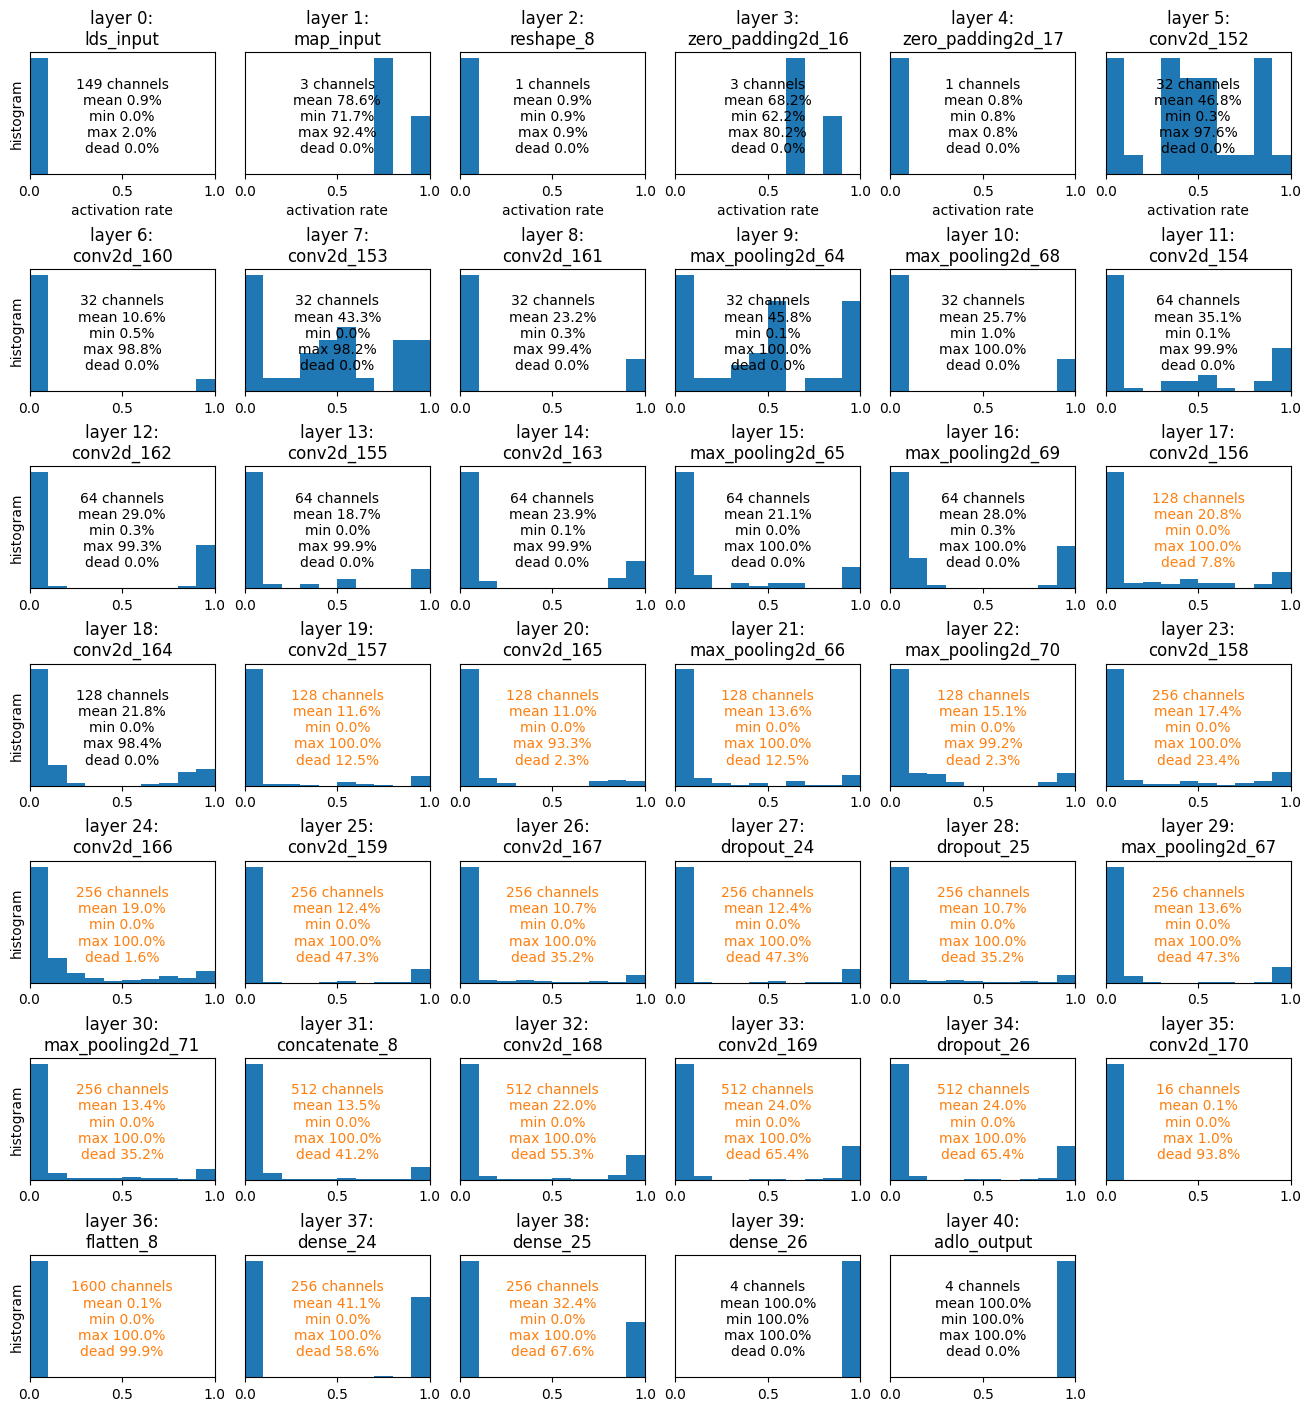

In [144]:
reload(toolkit)
toolkit.plot_channel_stats(layer_channel_activity, model)

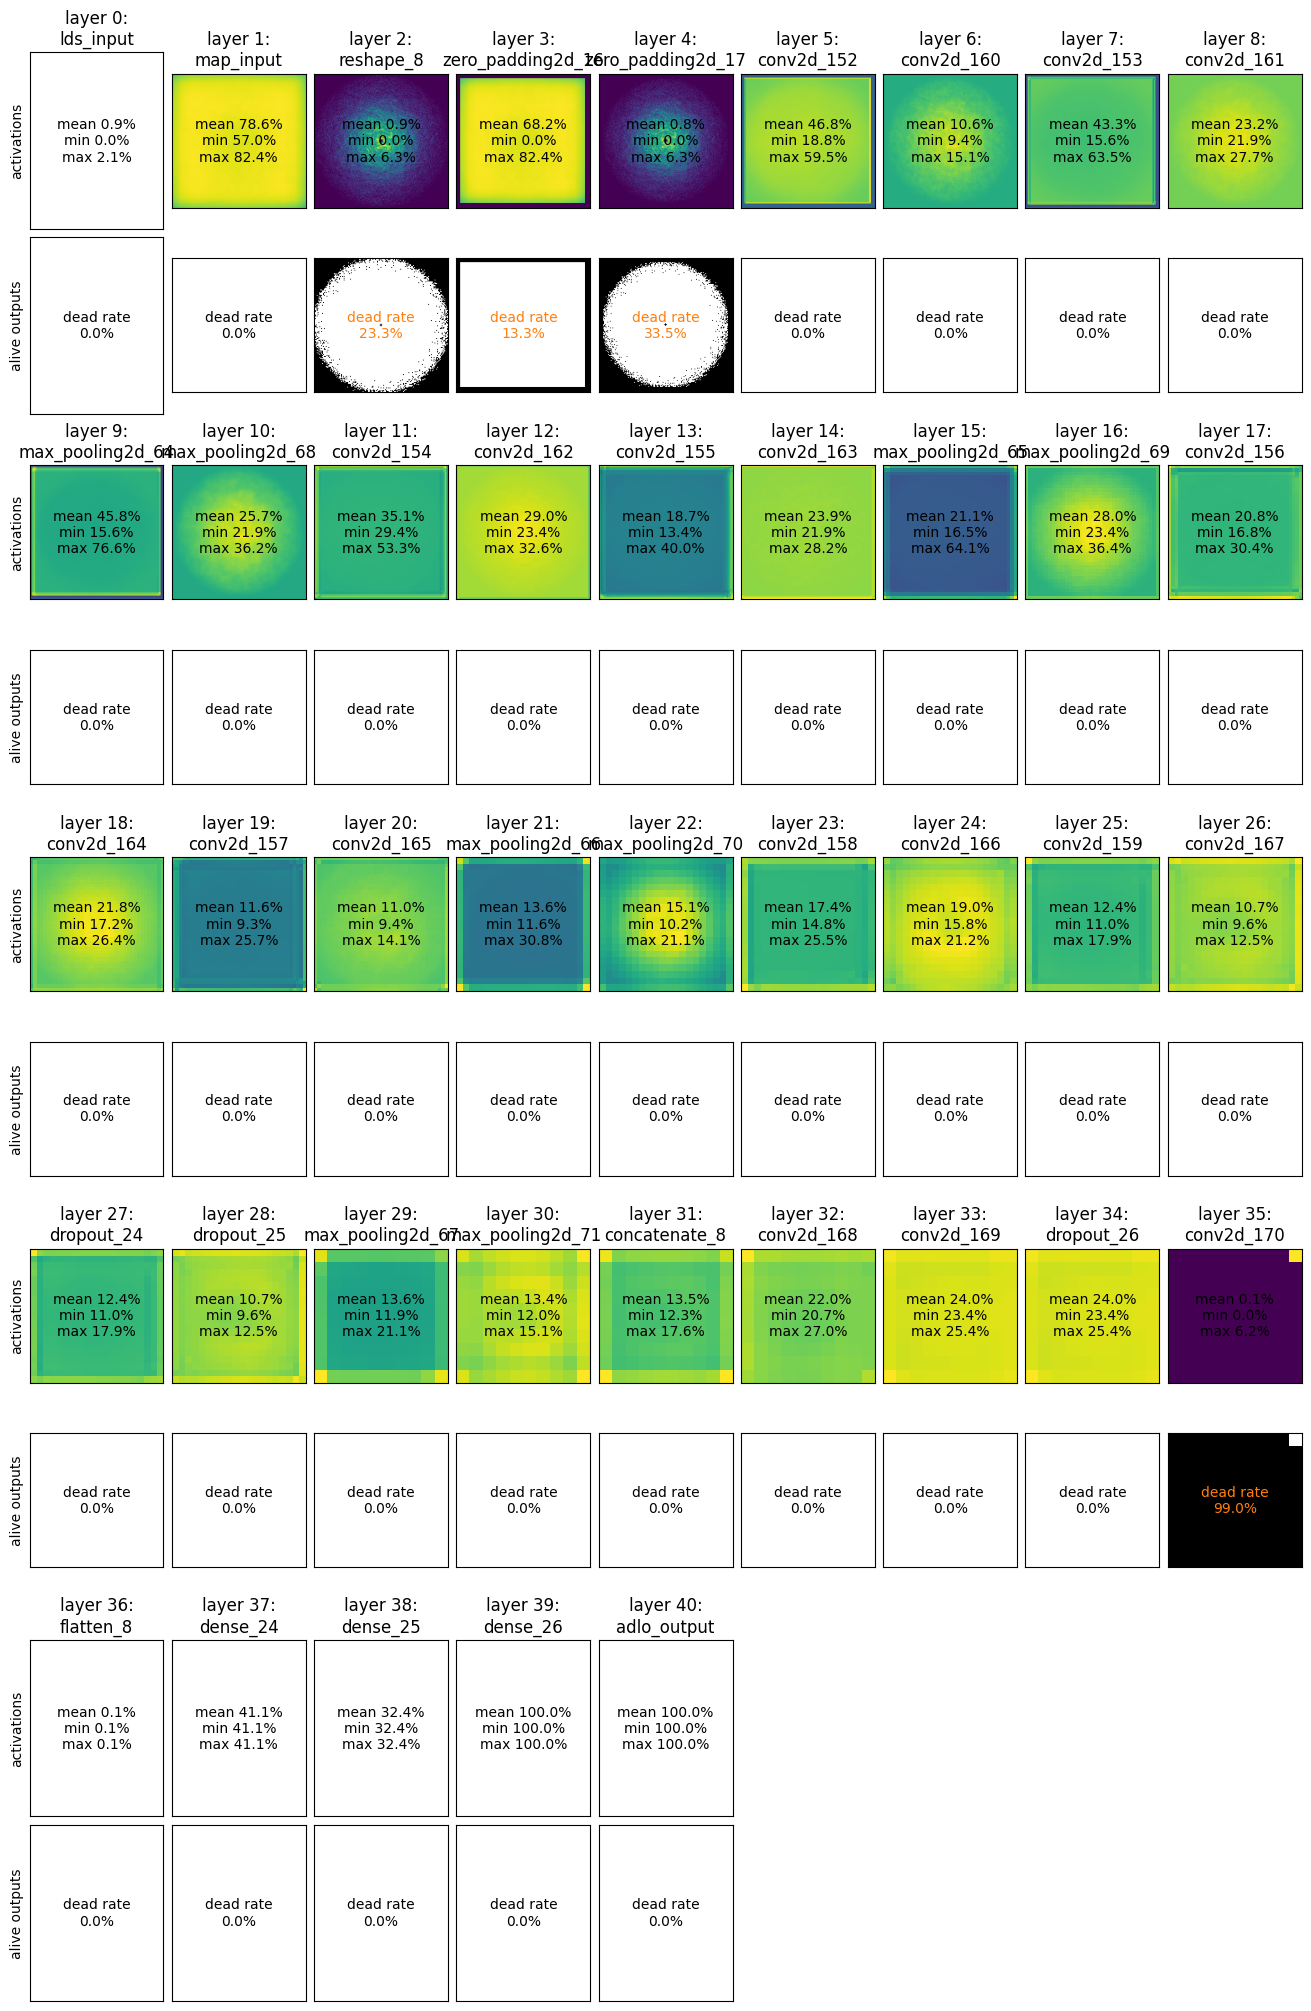

In [145]:
toolkit.plot_spatial_stats(layer_spatial_activity, model)

Something's very off with the activation rates in layer 35.
Curiously it shows up when you look at both the channel and spatial dimensions.
Let's sanity check if there's anything obvious with the weights for that layer, but looking at those weights across different axis.

In [146]:
l_idx = 35
print(f"layer {l_idx}: {model.layers[l_idx].name}")
print(f"layer weights: {model.layers[l_idx].weights[0].shape}")
print(f"layer biases: {model.layers[l_idx].weights[1].numpy()}")


layer 35: conv2d_170
layer weights: (3, 3, 512, 16)
layer biases: [-0.00619686 -0.0060054  -0.00600545 -0.00924858 -0.00380409 -0.00600543
 -0.00600535 -0.00967691 -0.00377345 -0.00443262 -0.00600538 -0.00600536
 -0.00261373  0.00384356 -0.00600545 -0.00712246]


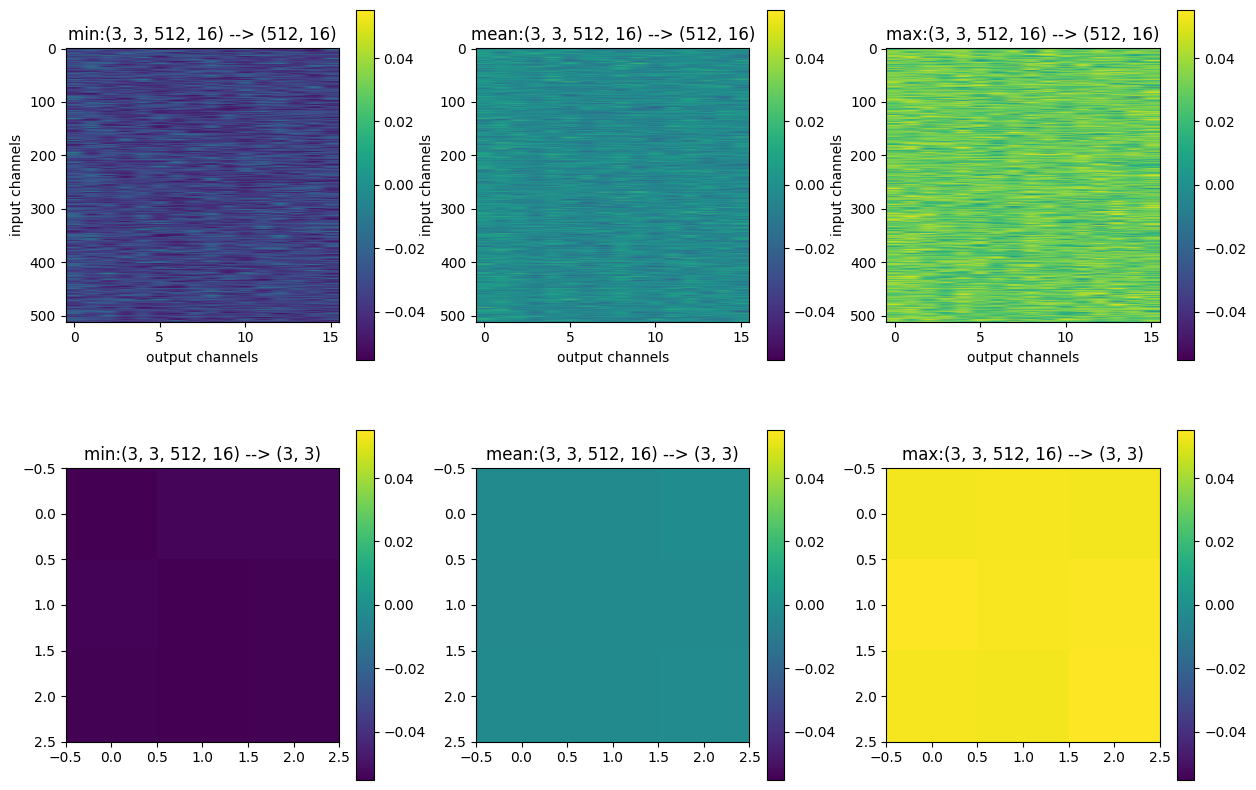

In [180]:
w = model.layers[l_idx].weights[0]
plot_conv_layer_values(w)

Next, what's going on with the individual unit gradients on this layer?


In [148]:
# train for one additional epoch and collect raw gradients
epochs = 1
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

activity2 = toolkit.ActivityRateCallback(model_train_data, interval=1)
gradients2 = toolkit.GradientHistoryCallback(verbose=3)
model_history2 = toolkit.fit(model, model_train_data, epochs=epochs, gradient_callback=gradients2, callbacks=[activity2])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - accept_accuracy: 0.7812 - adlo_loss: 1.2478 - loc_error: 0.1086 - loss: 1.2478 - orientation_error: 0.2880

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - accept_accuracy: 0.7425 - adlo_loss: 1.1875 - loc_error: 0.1064 - loss: 1.1770 - orientation_error: 0.2000


In [176]:
# Look at the gradients of just our target layer: #35
l_idx=35
variable_indices = gradients2._variable_indices_by_layer[l_idx]
print(f"gradients_list: {len(gradients2.gradients_list)} steps x {type(gradients2.gradients_list[0])} x {len(gradients2.gradients_list[0])} gradients x {type(gradients2.gradients_list[0][0])}")
print(f"layer {l_idx} - gradients at indices {variable_indices}:")
for index in variable_indices:
  print(f"  {index}: {gradients2.gradients_list[0][index].shape}")

print(f"biases: {gradients2.gradients_list[0][variable_indices[1]]}")

gradients_list: 32 steps x <class 'list'> x 44 gradients x <class 'tensorflow.python.framework.ops.EagerTensor'>
layer 35 - gradients at indices [36, 37]:
  36: (3, 3, 512, 16)
  37: (16,)
biases: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03027999  0.          0.        ]


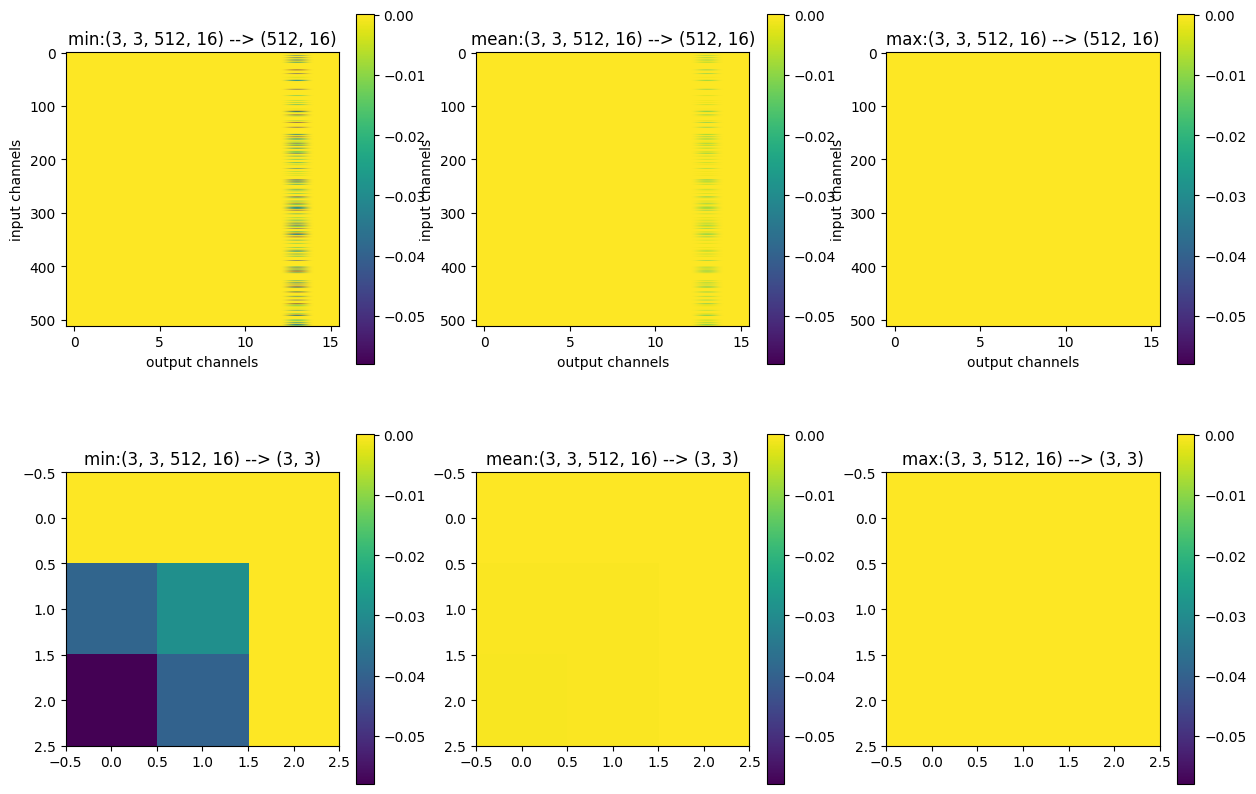

In [181]:
g = gradients2.gradients_list[0][variable_indices[0]]
plot_conv_layer_values(g)

## Full gradient info
At the risk of blowing out memory consumption, let's just simplistically see if we can collect all raw gradients during a short training run that hopefully gets close to the point of failure like we're getting.

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_389>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accept_accuracy: 0.6546 - adlo_loss: 3.2573 - loc_error: 0.2344 - loss: 1.9392 - orientation_error: 0.6350
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accept_accuracy: 0.7480 - adlo_loss: 1.2947 - loc_error: 0.1124 - loss: 1.2403 - orientation_error: 0.2028
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accept_accuracy: 0.7595 - adlo_loss: 1.2523 - loc_error: 0.1085 -

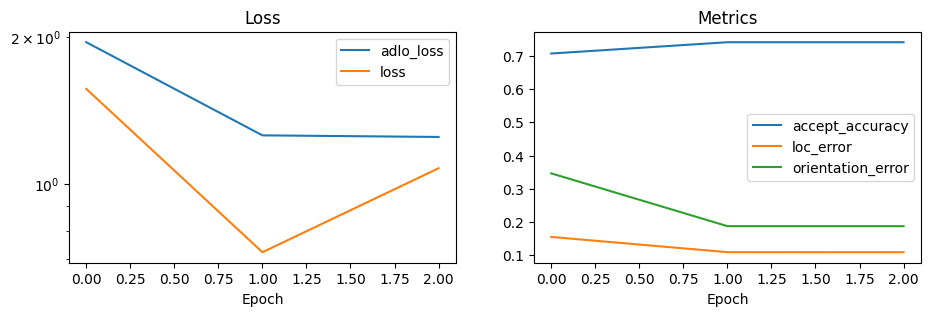

In [178]:
# Let's re-train with training visualisations enabled
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 3
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, verbose_history=True)

activity = toolkit.ActivityRateCallback(model_train_data, interval=1)
gradients = toolkit.GradientHistoryCallback(verbose=3)
model_history = toolkit.fit(model, model_train_data, epochs=epochs, gradient_callback=gradients, callbacks=[activity])

display_history(model_history)

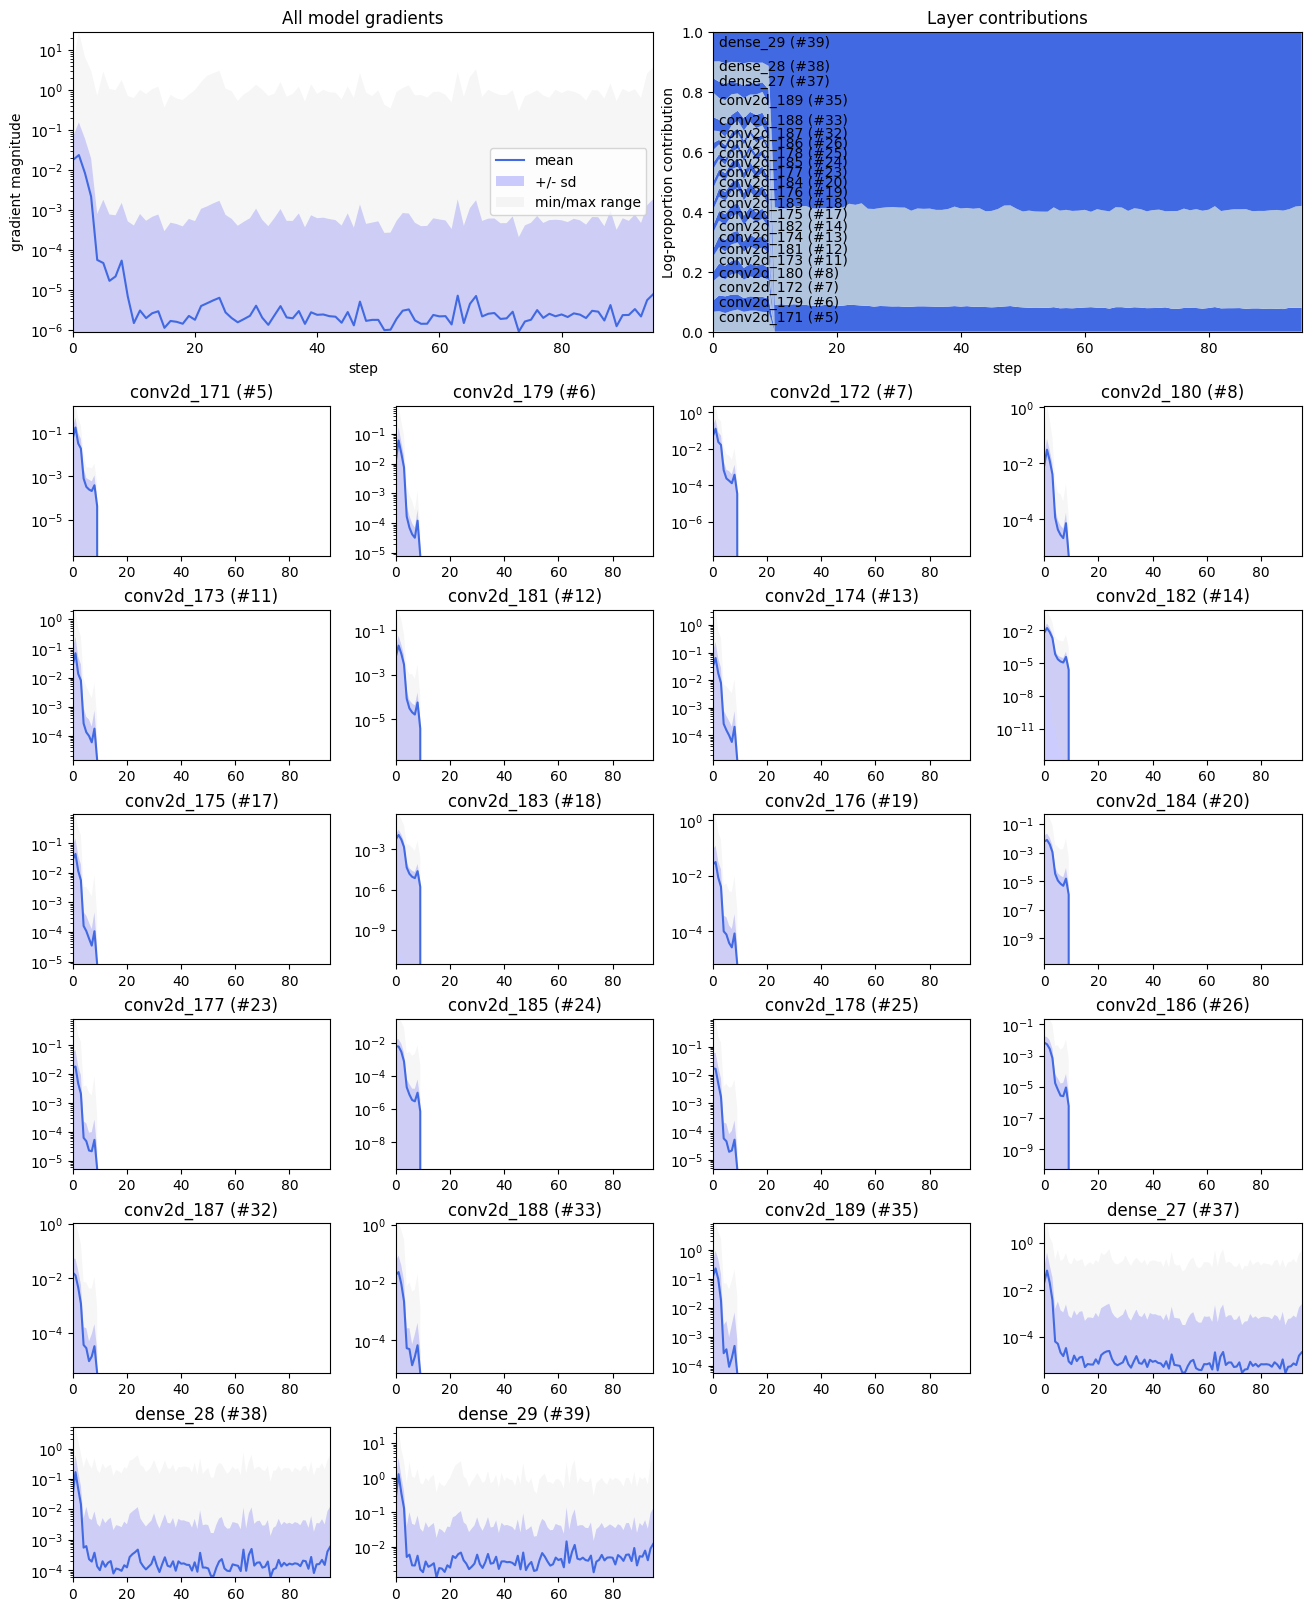

In [182]:
gradients.plot_summary()

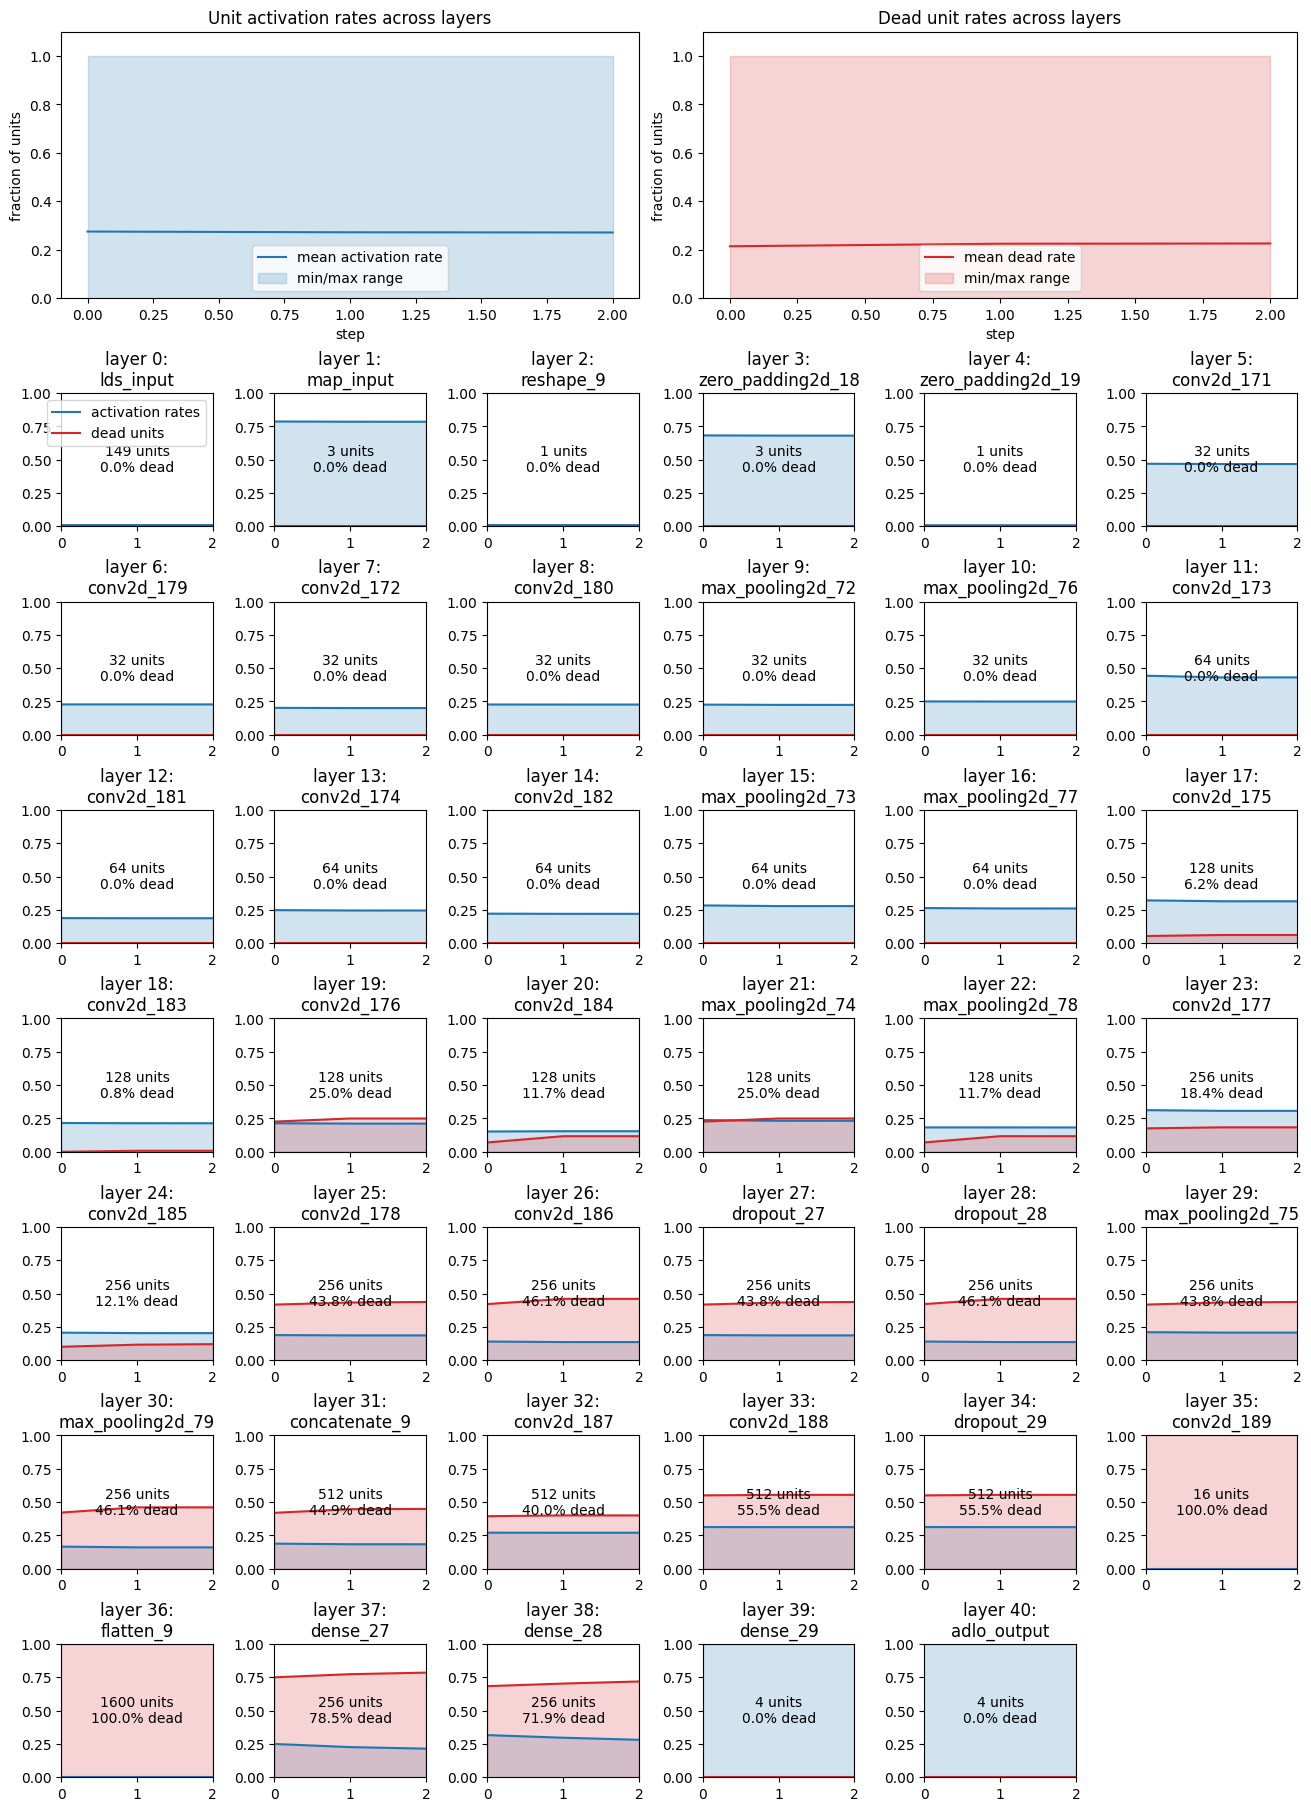

In [183]:
toolkit.plot_unit_activity(activity)

In [184]:
# and spatial activations after training
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = toolkit.measure_unit_activity(model, model_train_data, include_channel_activity=True, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]

model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 1.0, 'mean_dead_rate': 0.22603849085365854, 'min_activation_rate': 0.0, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.27123955}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.009257836}, {'dead_rate': 0.0, 'activation_rate': 0.7807216}, {'dead_rate': 0.0, 'activation_rate': 0.009257836}, {'dead_rate': 0.0, 'activation_rate': 0.67706233}, {'dead_rate': 0.0, 'activation_rate': 0.00802864}, {'dead_rate': 0.0, 'activation_rate': 0.46683392}, {'dead_rate': 0.0, 'activation_rate': 0.22827193}, {'dead_rate': 0.0, 'activation_rate': 0.20068395}, {'dead_rate': 0.0, 'activation_rate': 0.22706081}, {'dead_rate': 0.0, 'activation_rate': 0.22443742}, {'dead_rate': 0.0, 'activation_rate': 0.24978738}, {'dead_rate': 0.0, 'activation_rate': 0.43104944}, {'dead_rate': 0.0, 'activation_rate': 0.18825275}, {'dead_rate': 0.0, 'activation_rate': 0.24591821}, {'dead_rate': 0.0, 'activation_rate': 0.221217}, {'dead_rate': 0.0, 'activation_ra

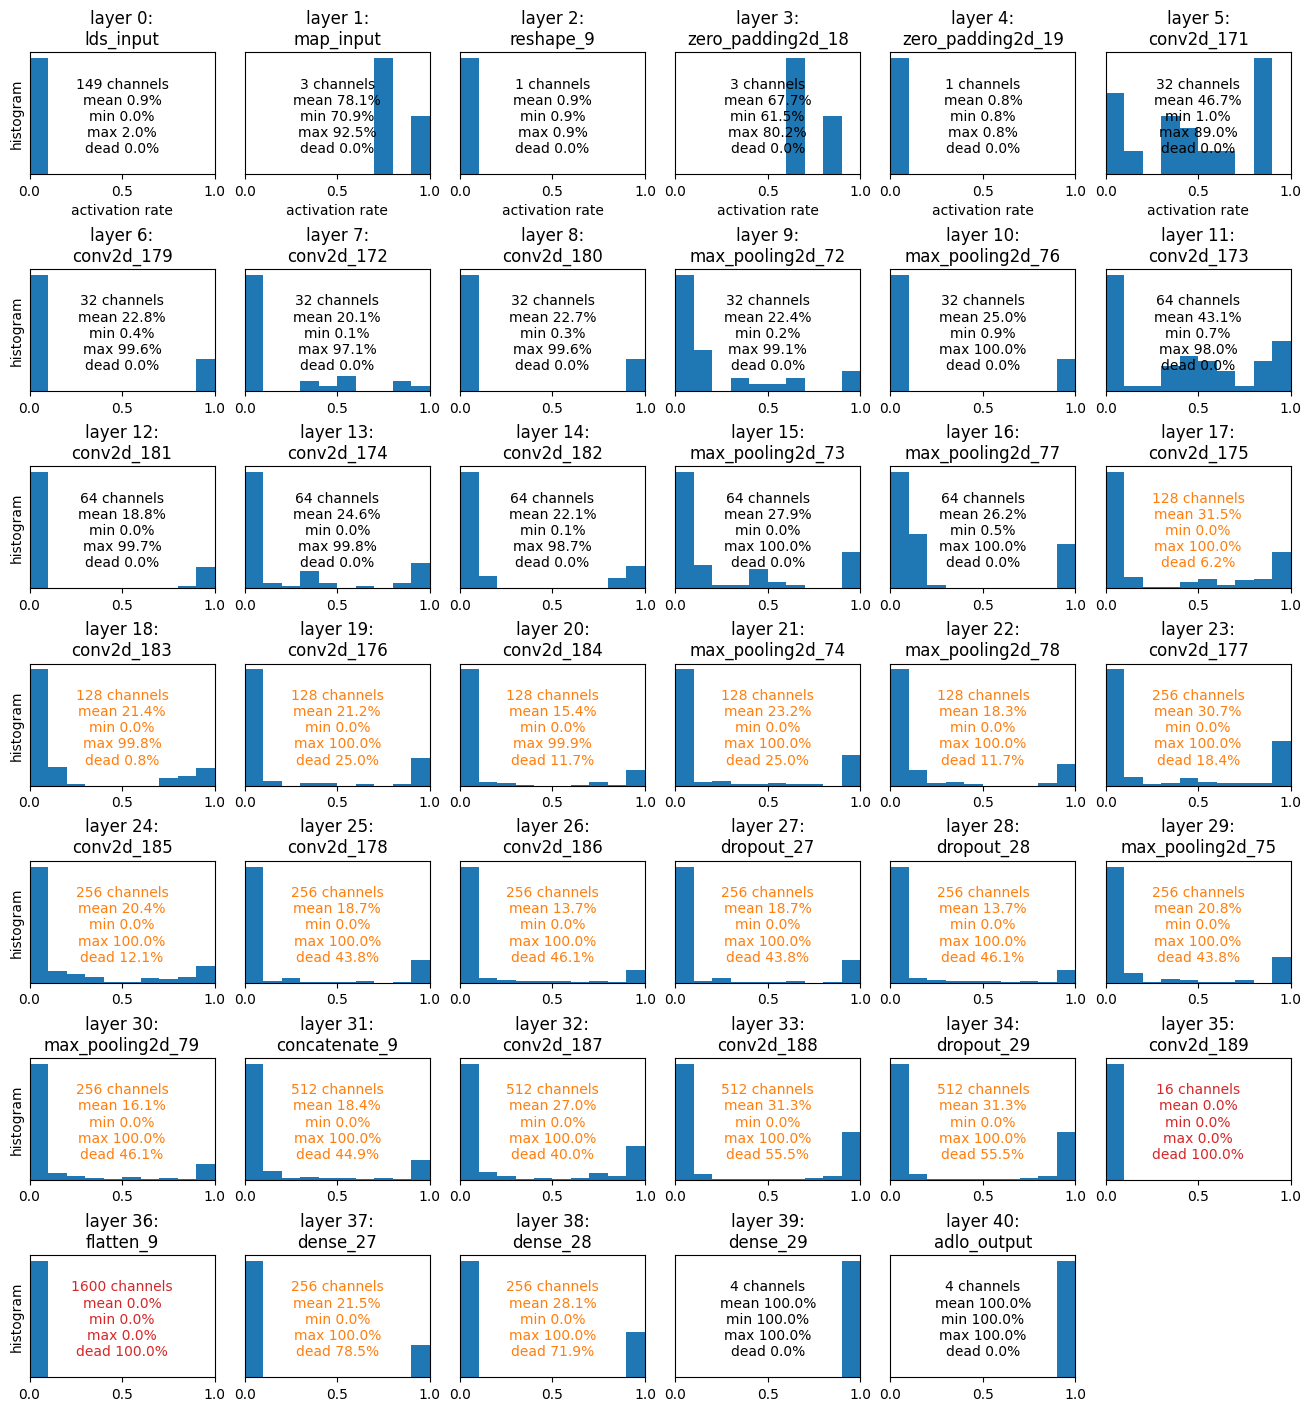

In [185]:
toolkit.plot_channel_stats(layer_channel_activity, model)

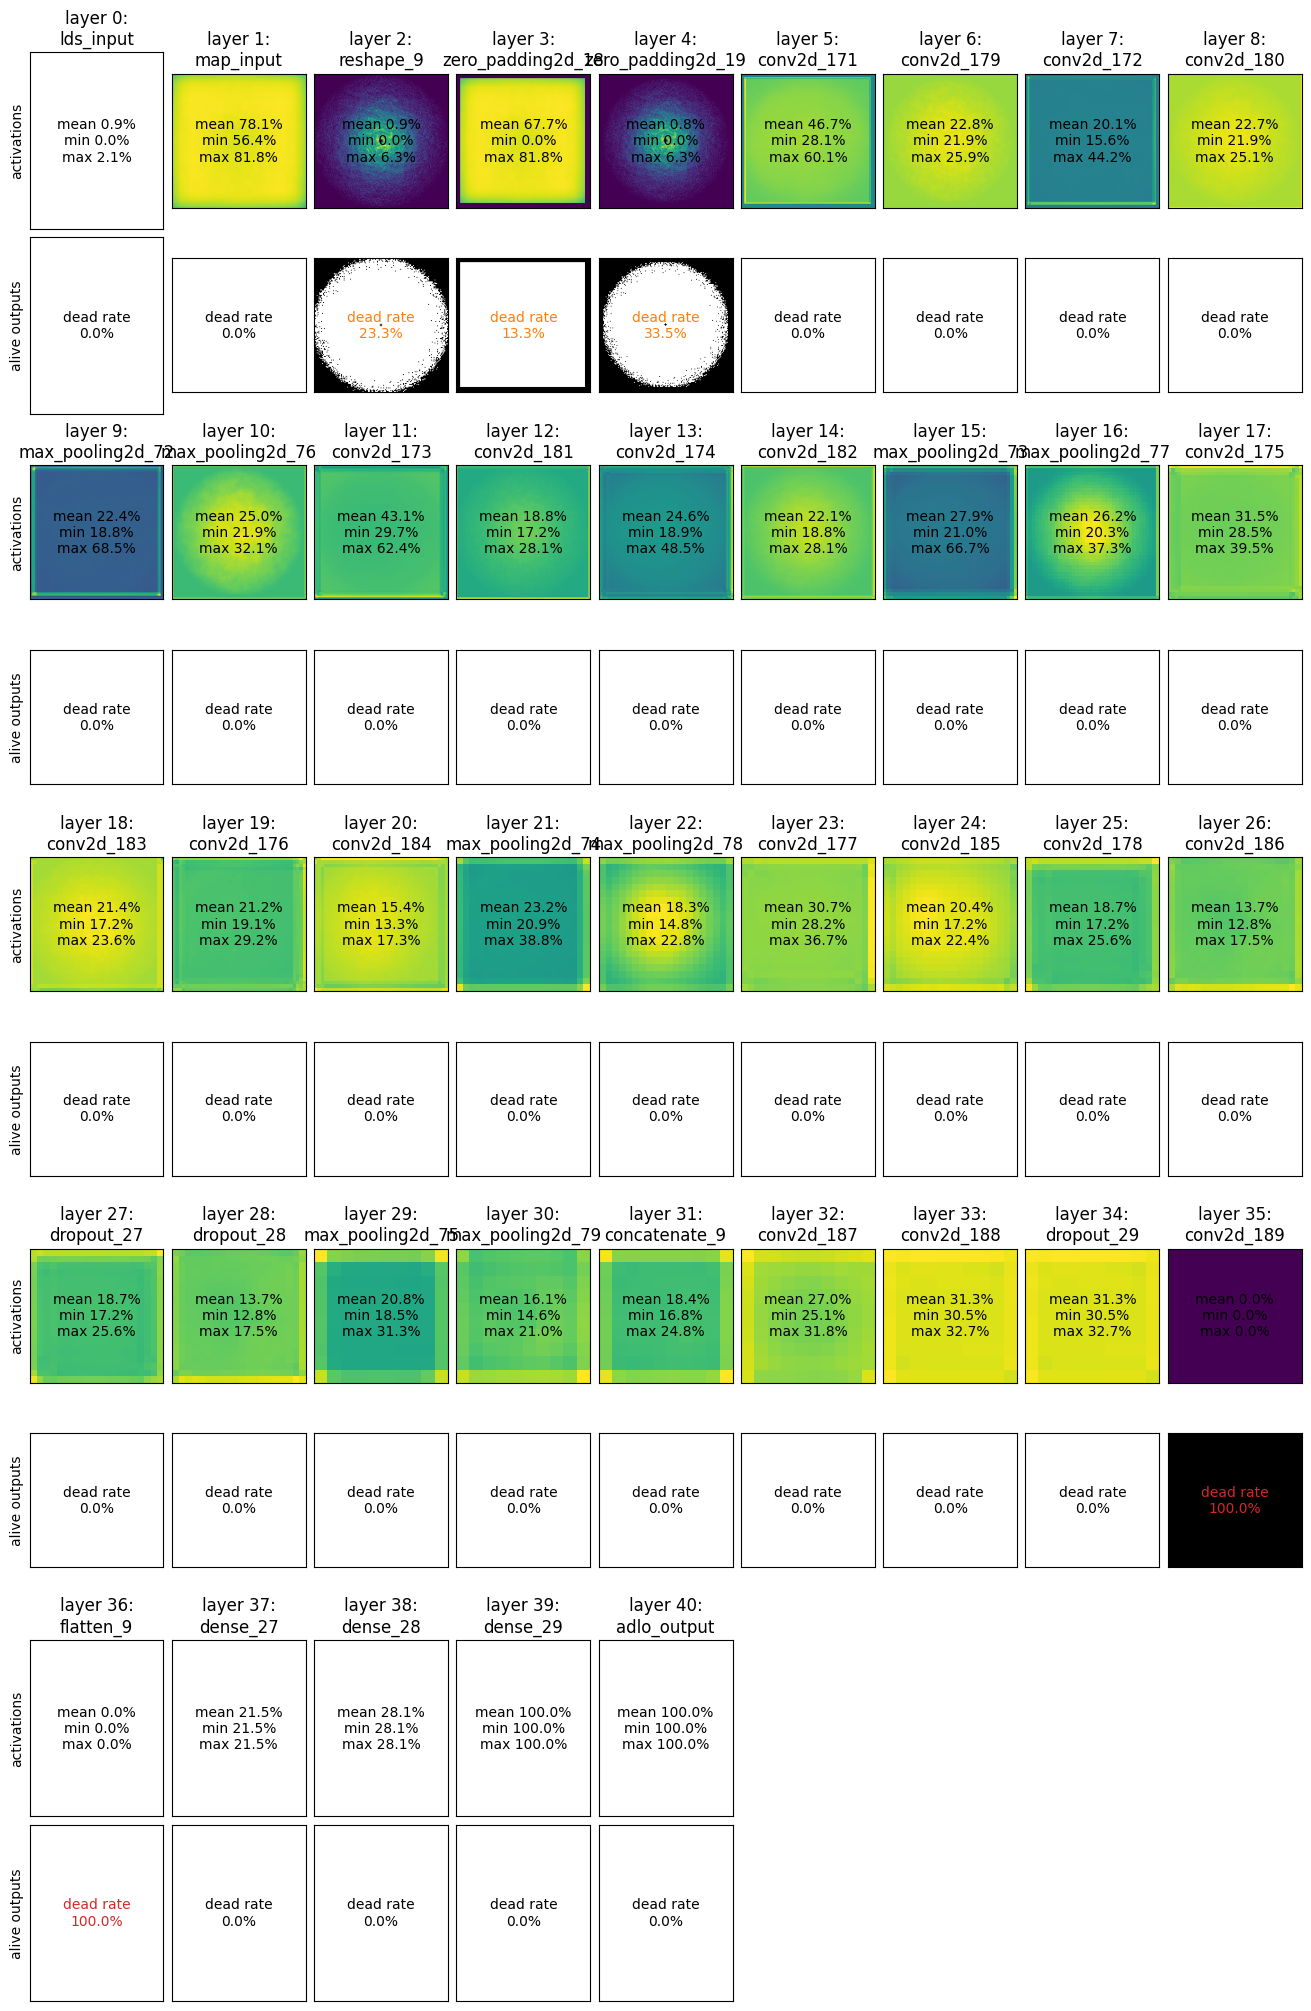

In [186]:
toolkit.plot_spatial_stats(layer_spatial_activity, model)

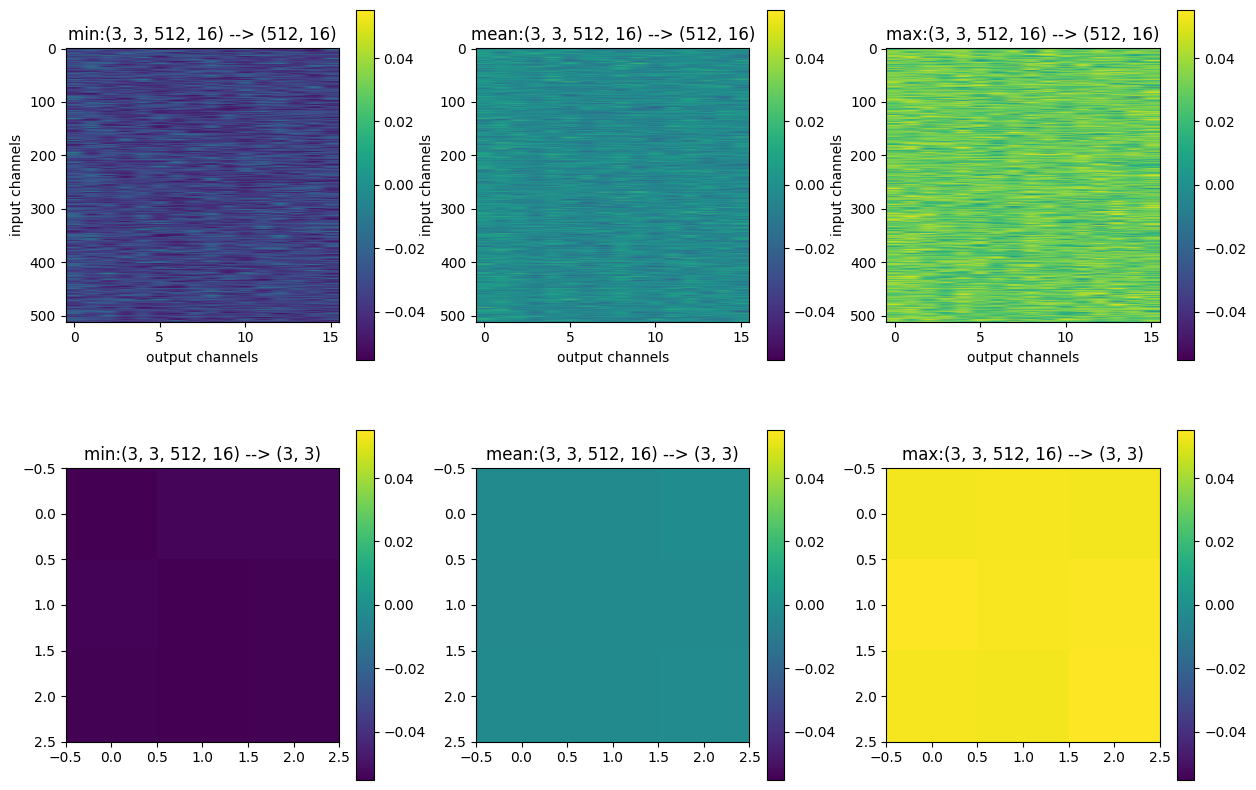

In [187]:
w = model.layers[l_idx].weights[0]
plot_conv_layer_values(w)

In [188]:
# Look at the gradients of just our target layer: #35
l_idx=35
variable_indices = gradients._variable_indices_by_layer[l_idx]
print(f"gradients_list: {len(gradients.gradients_list)} steps x {type(gradients.gradients_list[0])} x {len(gradients.gradients_list[0])} gradients x {type(gradients.gradients_list[0][0])}")
print(f"layer {l_idx} - gradients at indices {variable_indices}:")
for index in variable_indices:
  print(f"  {index}: {gradients.gradients_list[0][index].shape}")

print(f"biases: {gradients.gradients_list[0][variable_indices[1]]}")

gradients_list: 96 steps x <class 'list'> x 44 gradients x <class 'tensorflow.python.framework.ops.EagerTensor'>
layer 35 - gradients at indices [36, 37]:
  36: (3, 3, 512, 16)
  37: (16,)
biases: [-9.52416509e-02 -1.67520463e-01 -4.40145954e-02  7.48446941e-01
 -1.92981720e-01  6.05780363e-01  9.31004405e-01  5.64909339e-01
 -1.07026845e-02 -7.29180872e-04  1.34721386e+00  2.43623972e-01
 -2.15717226e-01  2.50968099e-01  2.90872604e-02  1.85527503e-01]


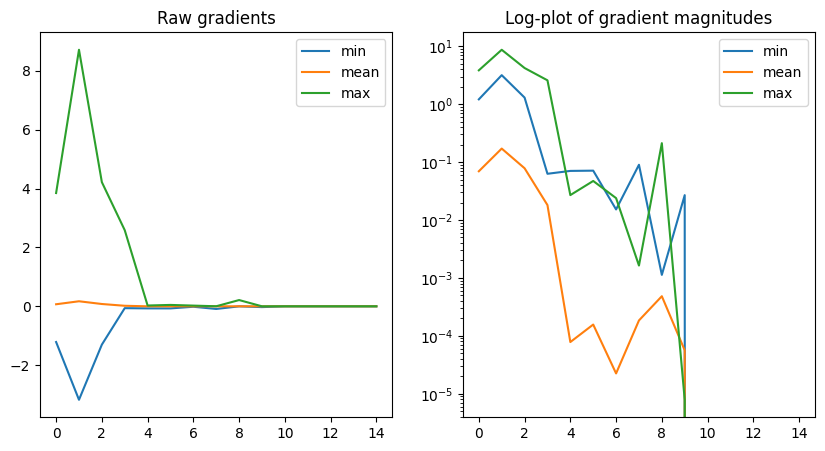

In [204]:
min_grads = np.array([tf.reduce_min(grads[variable_indices[0]]) for grads in gradients.gradients_list])
mean_grads = np.array([tf.reduce_mean(grads[variable_indices[0]]) for grads in gradients.gradients_list])
max_grads = np.array([tf.reduce_max(grads[variable_indices[0]]) for grads in gradients.gradients_list])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Raw gradients')
plt.plot(min_grads[0:15], label='min')
plt.plot(mean_grads[0:15], label='mean')
plt.plot(max_grads[0:15], label='max')
plt.legend()

plt.subplot(1,2,2)
plt.title('Log-plot of gradient magnitudes')
plt.plot(np.abs(min_grads)[0:15], label='min')
plt.plot(np.abs(mean_grads)[0:15], label='mean')
plt.plot(np.abs(max_grads)[0:15], label='max')
plt.legend()
plt.yscale('log')

plt.show()

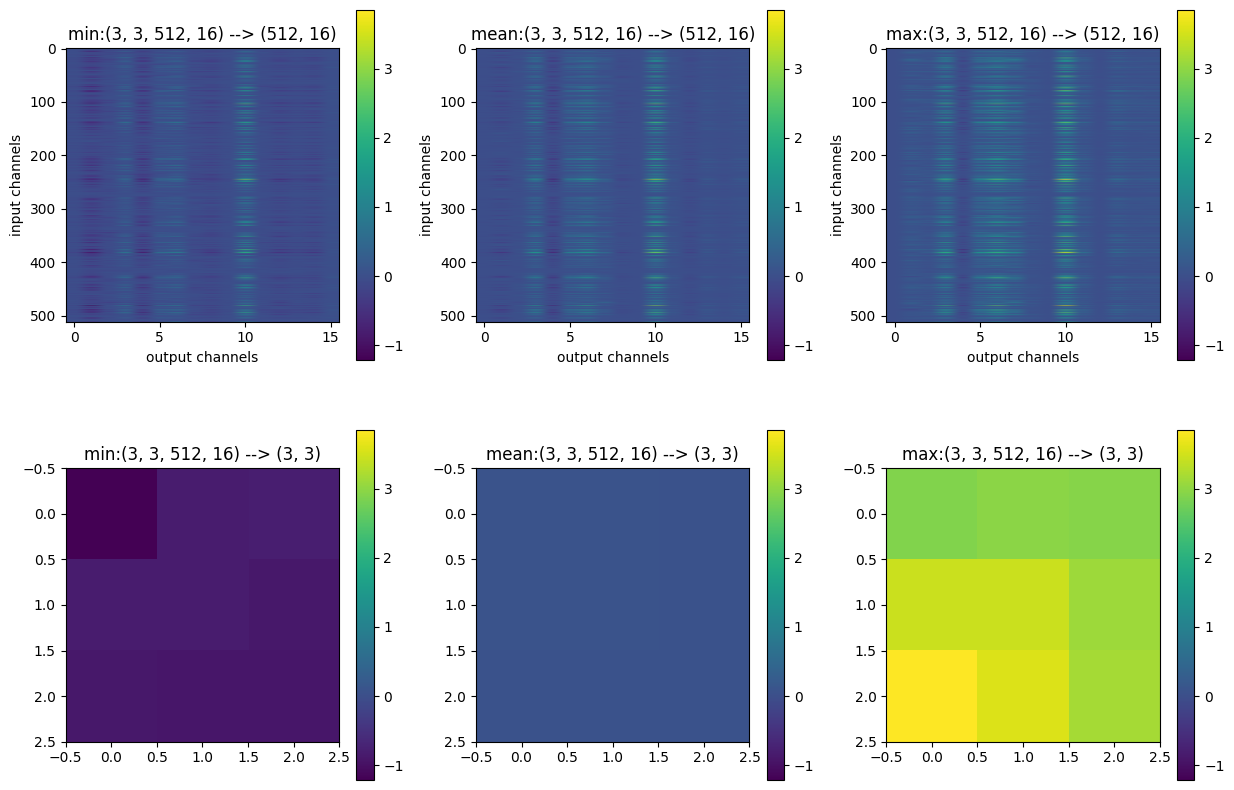

In [189]:
# layer 35 gradients at start
g = gradients.gradients_list[0][variable_indices[0]]
plot_conv_layer_values(g)

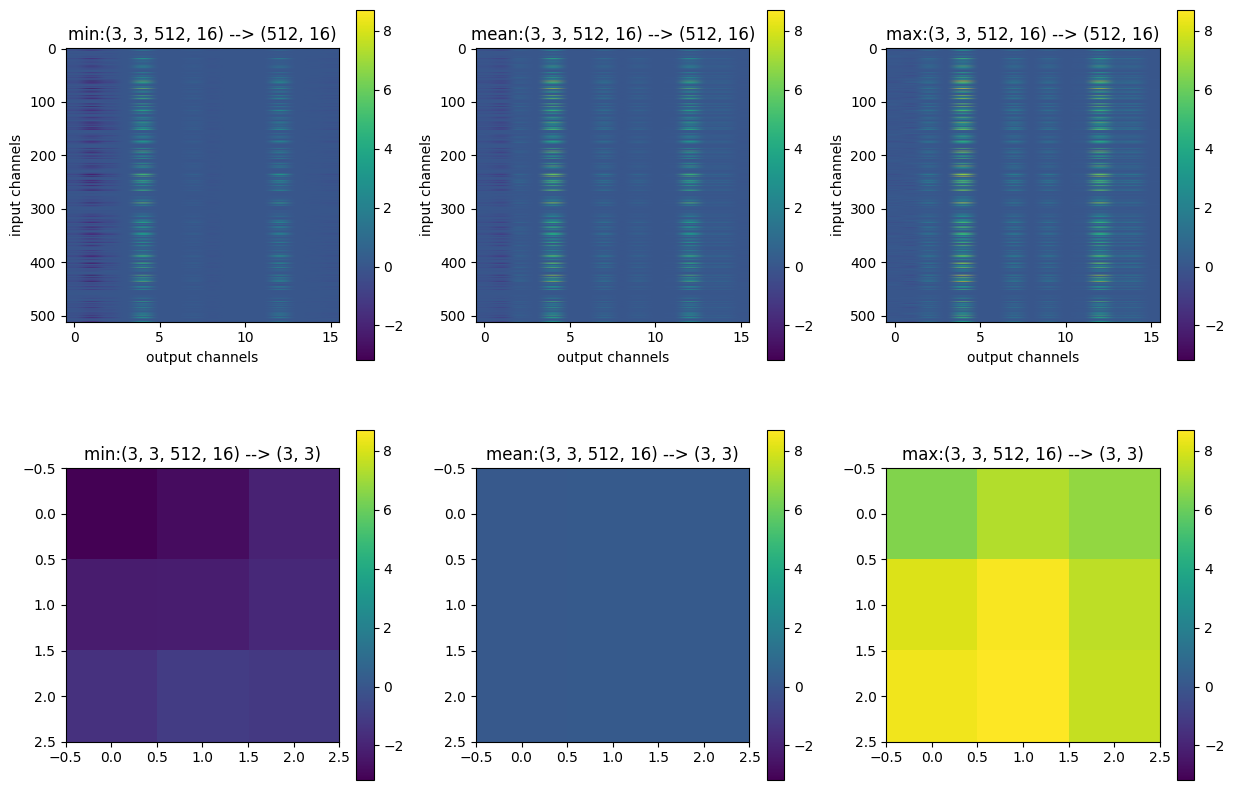

In [205]:
# layer 35 gradients at step 1
g = gradients.gradients_list[1][variable_indices[0]]
plot_conv_layer_values(g)

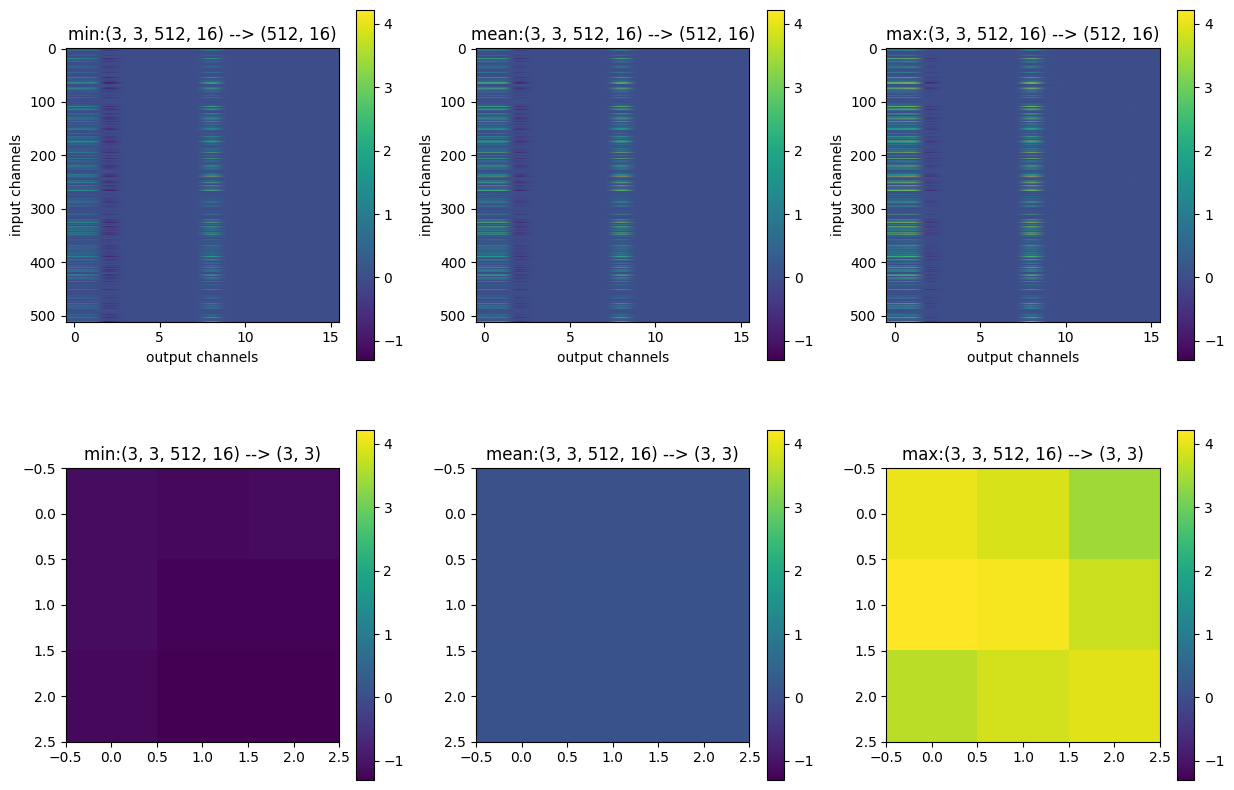

In [206]:
# layer 35 gradients at step 2
g = gradients.gradients_list[2][variable_indices[0]]
plot_conv_layer_values(g)

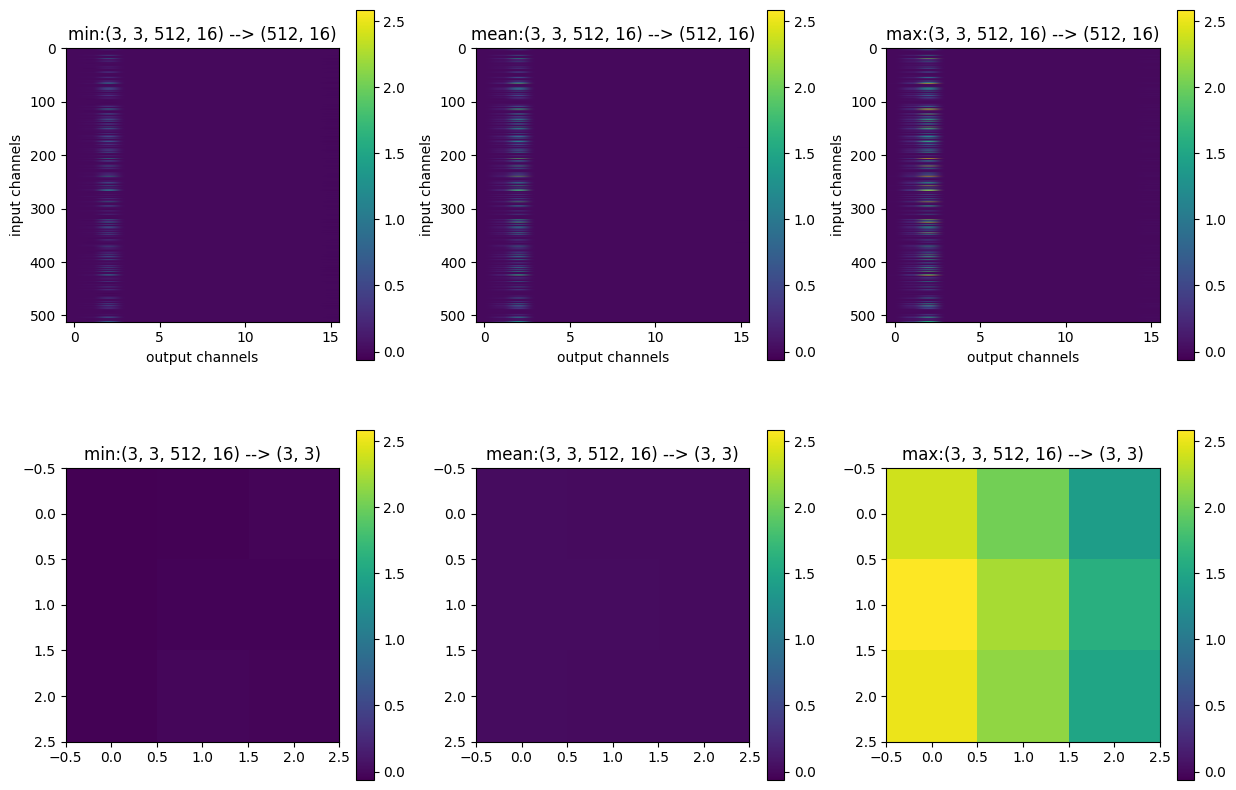

In [209]:
# layer 35 gradients at step 3
g = gradients.gradients_list[3][variable_indices[0]]
plot_conv_layer_values(g)

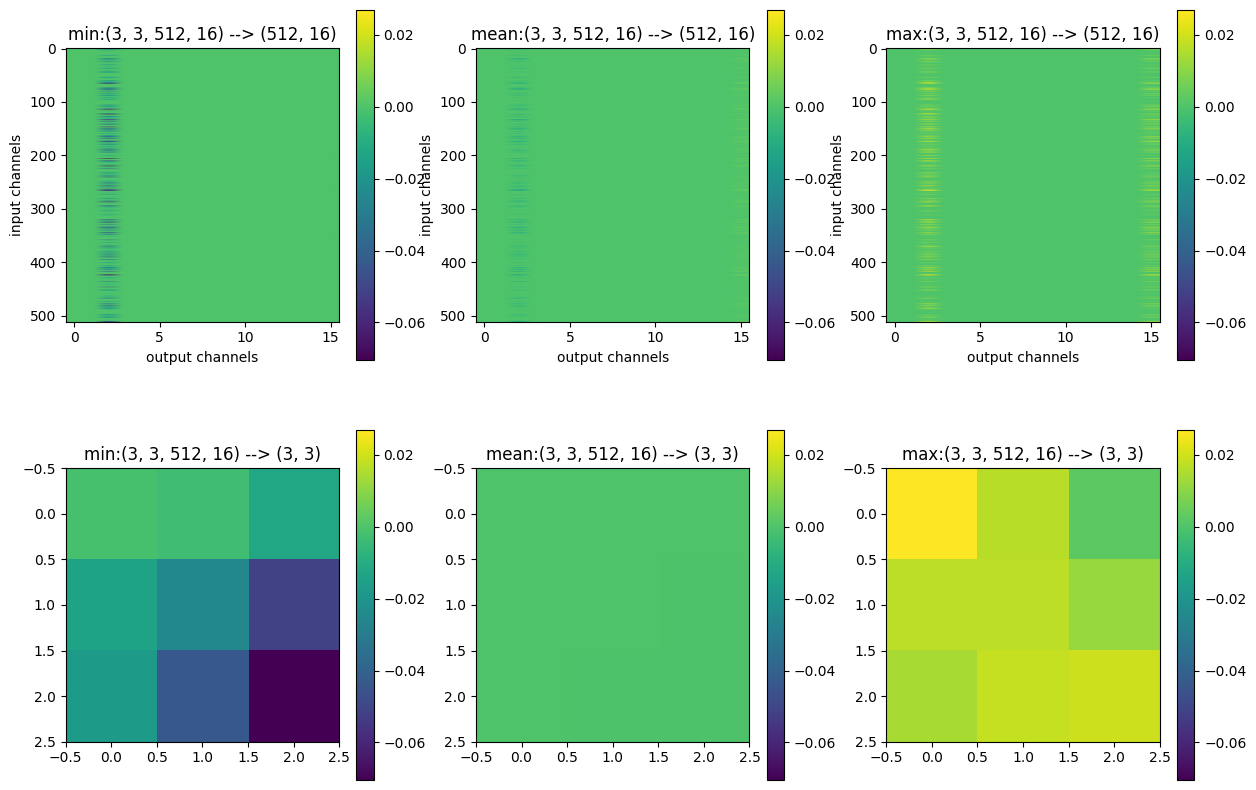

In [208]:
# layer 35 gradients at step 4
g = gradients.gradients_list[4][variable_indices[0]]
plot_conv_layer_values(g)

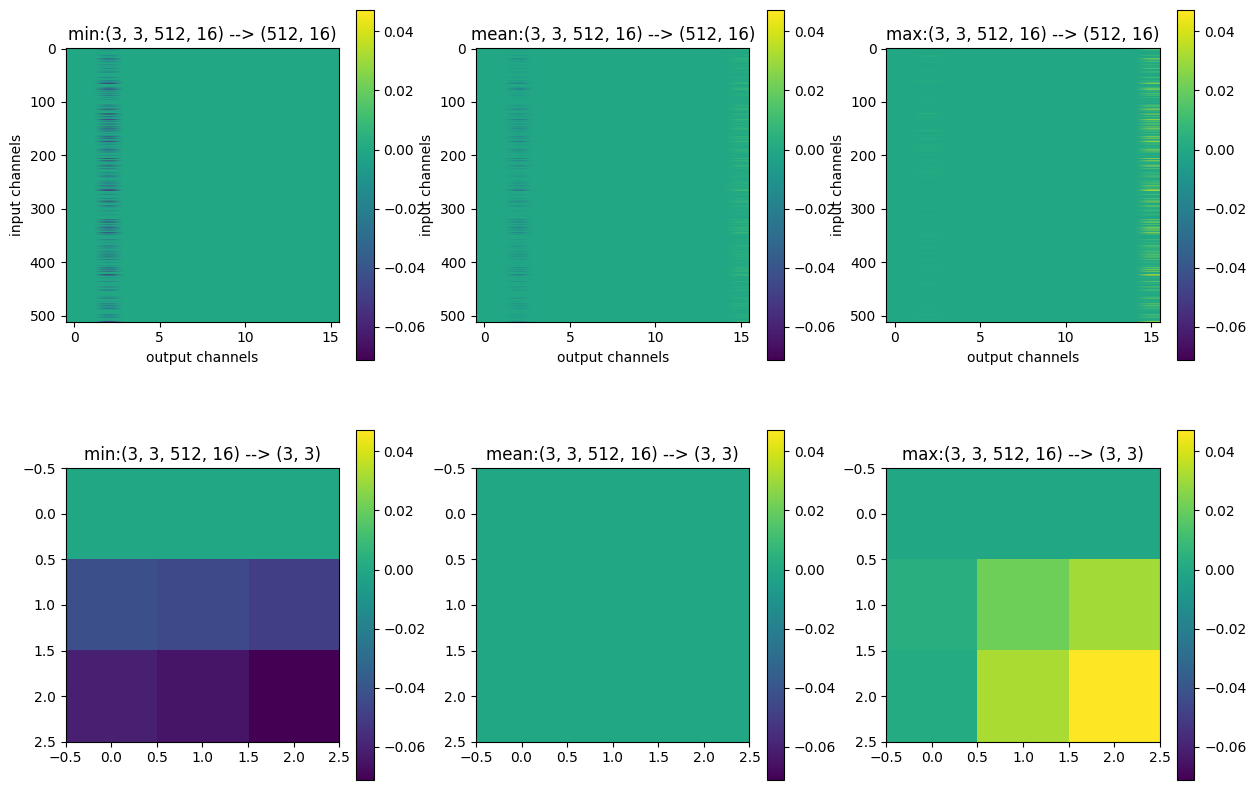

In [191]:
# layer 35 gradients at step 5 (about 2/3rd towards collapse point)
g = gradients.gradients_list[5][variable_indices[0]]
plot_conv_layer_values(g)

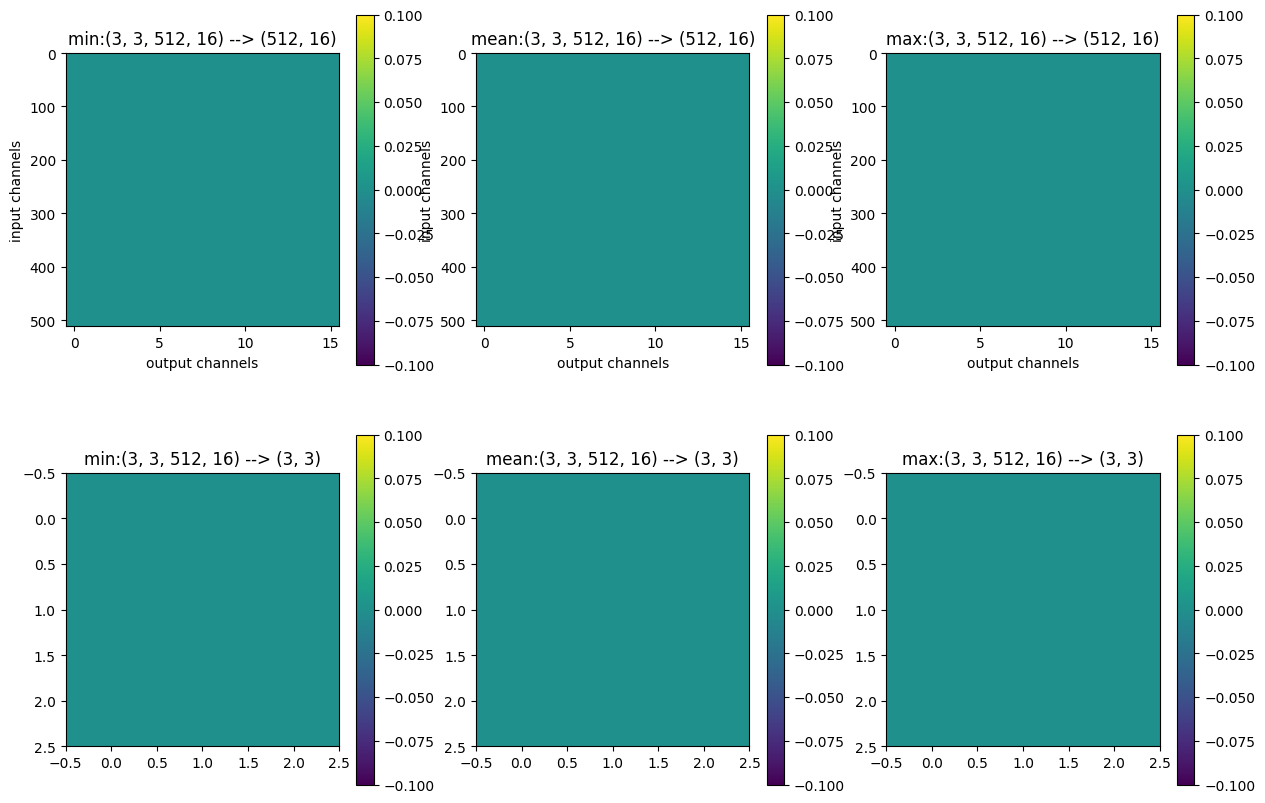

In [190]:
# layer 35 gradients at end
g = gradients.gradients_list[-1][variable_indices[0]]
plot_conv_layer_values(g)

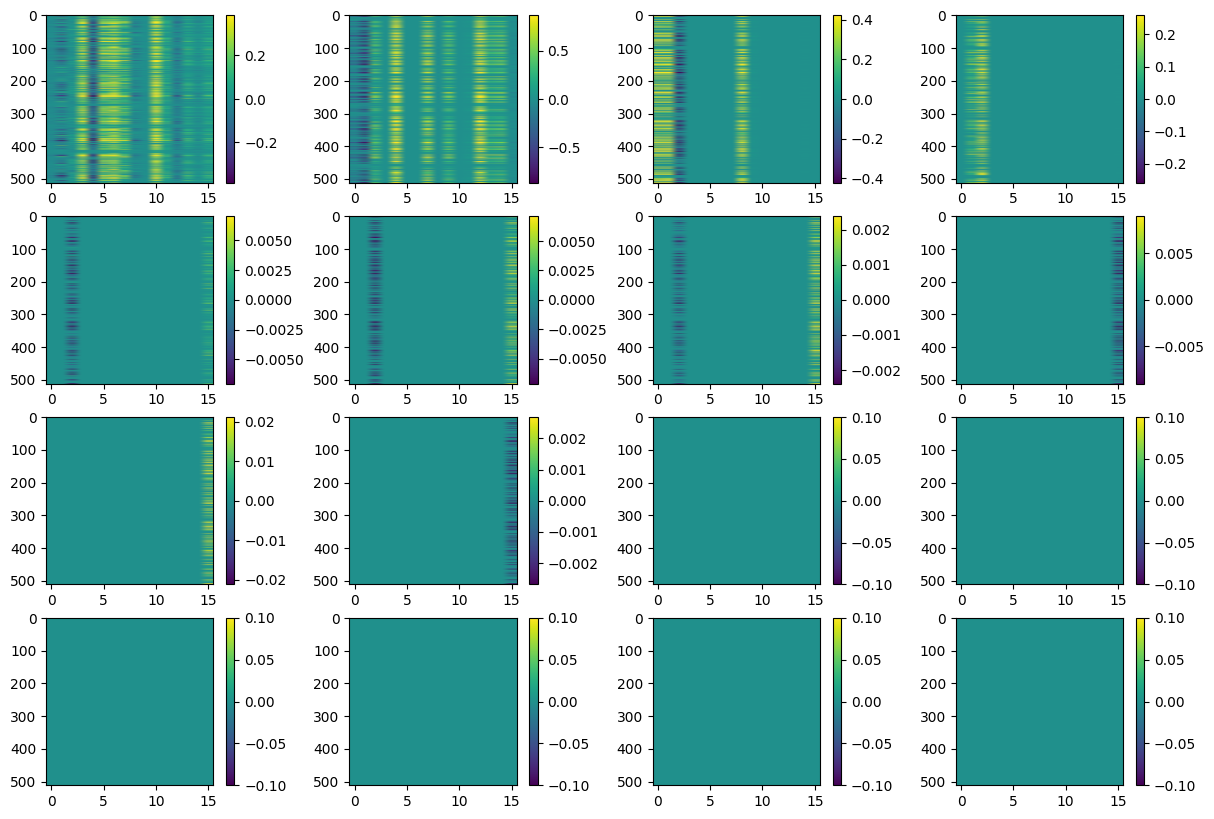

In [222]:
# Plot just the channel-to-channel means, with colorbar scaled to exaggerate contrast
ln=16
plt.figure(figsize=(15,10))
for step in range(0, ln):
  g = gradients.gradients_list[step][variable_indices[0]]
  g_min = tf.reduce_min(g)
  g_max = tf.reduce_max(g)
  vsz = max(abs(g_min), abs(g_max))
  mean = tf.reduce_mean(g, axis=(0, 1))
  plot_aspect = mean.shape[1] / mean.shape[0]

  plt.subplot(4, math.ceil(ln/4), step+1)
  plt.imshow(mean, aspect=plot_aspect, vmin=-vsz/10, vmax=vsz/10)
  plt.colorbar()

**Observations:**

* Gradients for all units hit zero on the 11th step.
* The number of live output channels (units) steadily reduces over time.
* Gradients on the output-channel axis stongly move as groups, in the same direction.
* What's inexplicable is that the raw weights at the end don't show any of this trend.

**Theories:**
* I think the output-channel grouping implies that there's pressure due to backprop from the next layer (as opposed to being activation pressure from the previous layer)
* This is further implied by the weights being good.

Remember:
* gradient at a given ReLU layer is a result of:
  * prev_layer_activations $\times$ 1 $\times$ current_layer_activation_bool_matrix $\times$ next_layer_backprop_gradients
* backprop gradients from next layer are result of:
  * current_layer_weights $\times$ current_layer_activation_bool_matrix $\times$ 1 $\times$ next_layer_activation_bool_matrix $\times$ ...

## Appendix: Untrained model
For reference to results above, let's look at what things look like for an entirely untrained model.

In [29]:
untrained_model = adlo_model((149, 149, 3), compile=True, verbose_history=True)
untrained_model.summary()

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_233>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lds_input (InputLayer)    │ (None, 149, 149)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 149, 149, 1)    │              0 │ lds_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 160, 160, 1)    │              0 │ reshape_5[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 160, 160, 32)   │            896 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 160, 160, 32)   │            320 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 160, 160, 32)   │          9,248 │ conv2d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 80, 80, 32)     │              0 │ conv2d_96[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_44          │ (None, 80, 80, 32)     │              0 │ conv2d_104[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_44[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 80, 80, 64)     │         36,928 │ conv2d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_105[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 40, 40, 64)     │              0 │ conv2d_98[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 40, 40, 64)     │              0 │ conv2d_106[0][0]       │
│ (MaxPooling2D)       

 Total params: 7,613,972 (29.04 MB)

 Trainable params: 7,613,972 (29.04 MB)

 Non-trainable params: 0 (0.00 B)

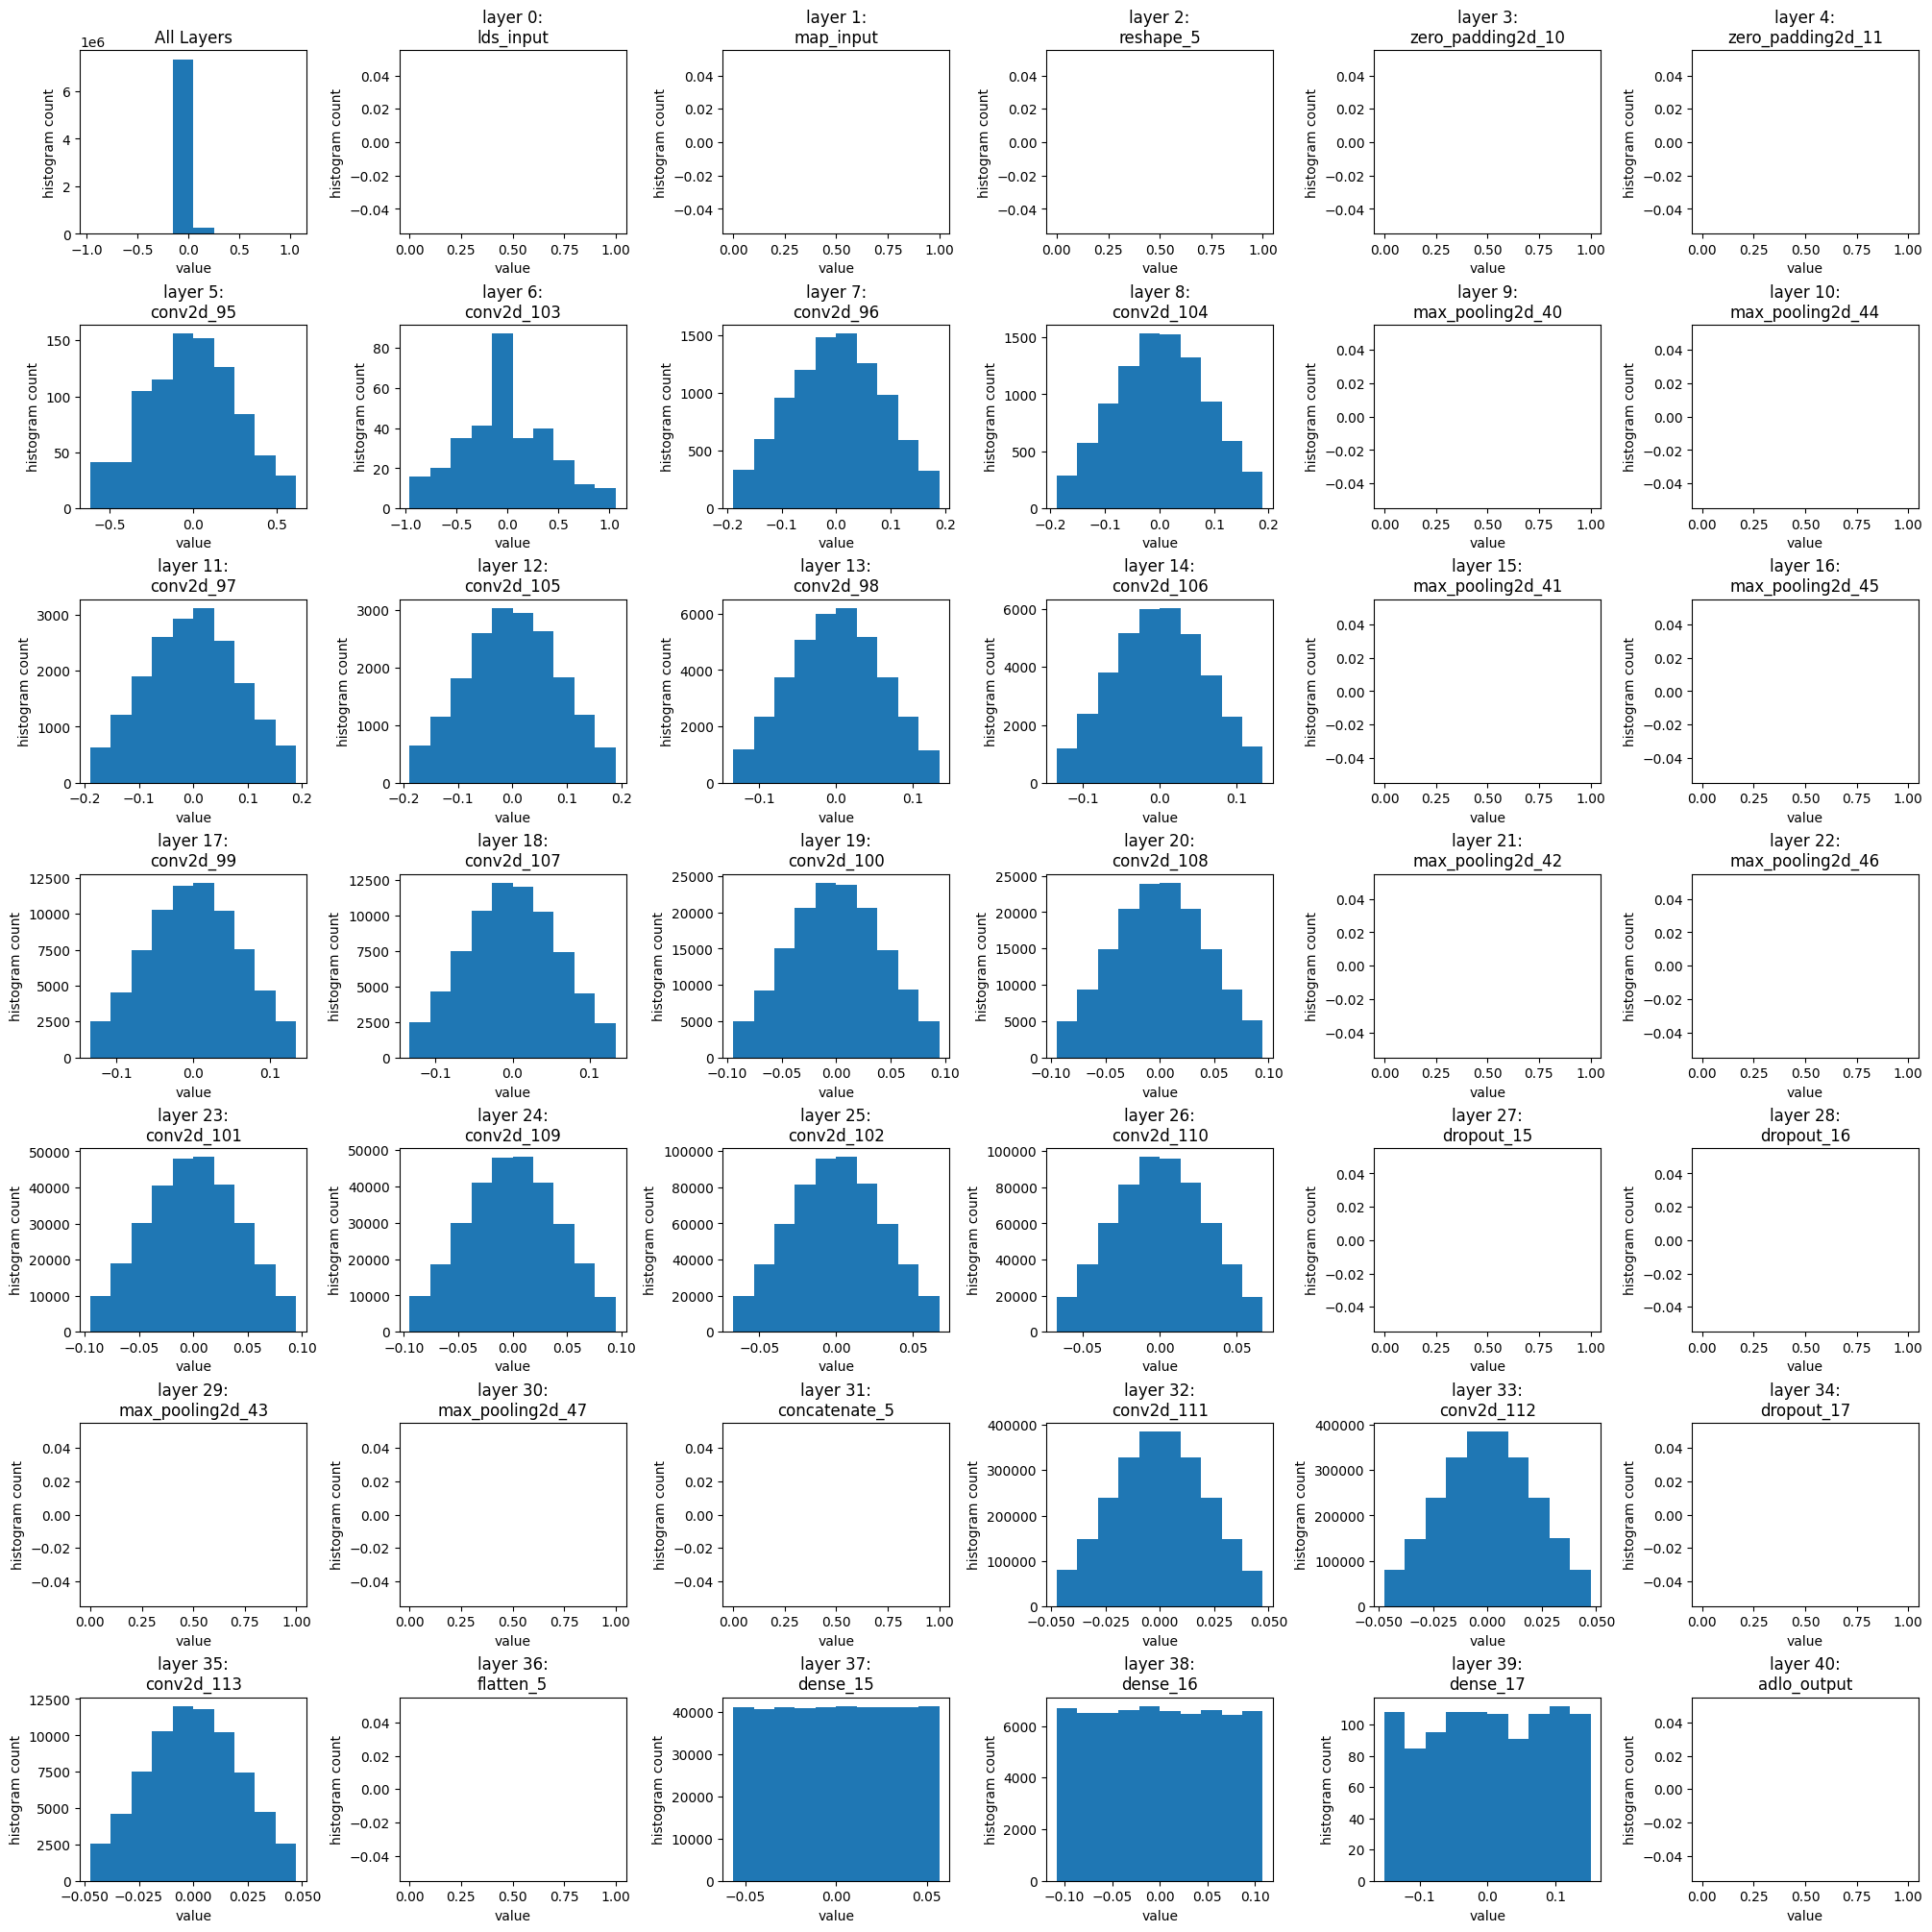

In [81]:
# weights for an untrained model
plot_weights(untrained_model, all_layers=True)

In [17]:
# collect model and layer stats from untrained model
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = toolkit.measure_unit_activity(untrained_model, model_train_data, include_channel_activity=True, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_155>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]

model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.19140625, 'mean_dead_rate': 0.01229611280487805, 'min_activation_rate': 0.008030129, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.41871923}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.00925955}, {'dead_rate': 0.0, 'activation_rate': 0.7788696}, {'dead_rate': 0.0, 'activation_rate': 0.009259551}, {'dead_rate': 0.0, 'activation_rate': 0.6754565}, {'dead_rate': 0.0, 'activation_rate': 0.008030129}, {'dead_rate': 0.0, 'activation_rate': 0.3933217}, {'dead_rate': 0.0, 'activation_rate': 0.017440964}, {'dead_rate': 0.0, 'activation_rate': 0.41327614}, {'dead_rate': 0.0, 'activation_rate': 0.02902909}, {'dead_rate': 0.0, 'activation_rate': 0.44391623}, {'dead_rate': 0.0, 'activation_rate': 0.054898396}, {'dead_rate': 0.0, 'activation_rate': 0.4775759}, {'dead_rate': 0.0, 'activation_rate': 0.07068715}, {'dead_rate': 0.0, 'activation_rate': 0.50857323}, {'dead_rate': 0.0, 'activation_rate': 0.09237398}, {'dead_rate': 0.0

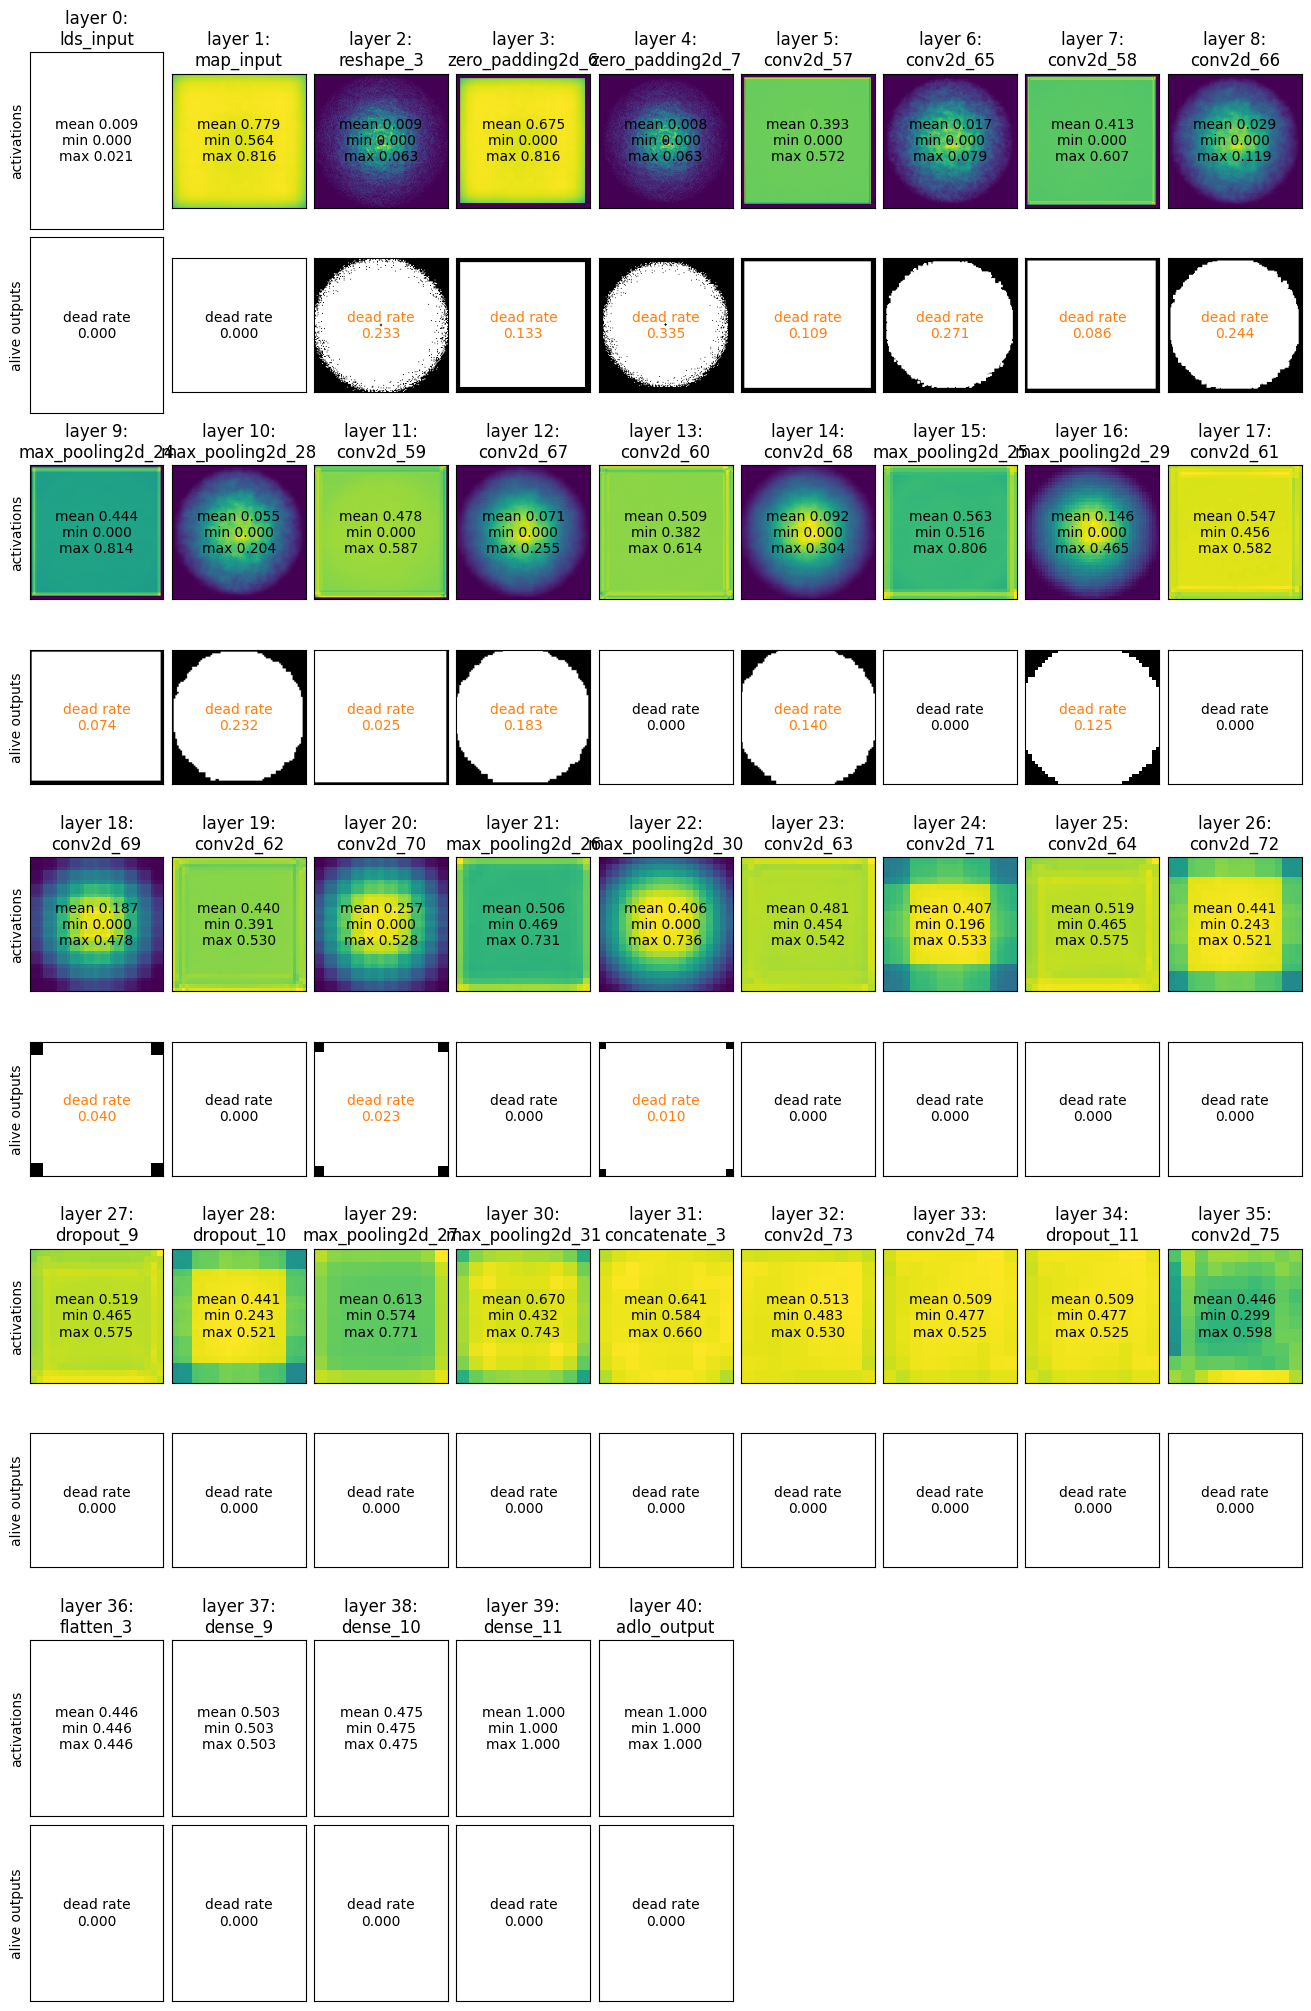

In [25]:
reload(toolkit)
toolkit.plot_spatial_stats(layer_spatial_activity, untrained_model)

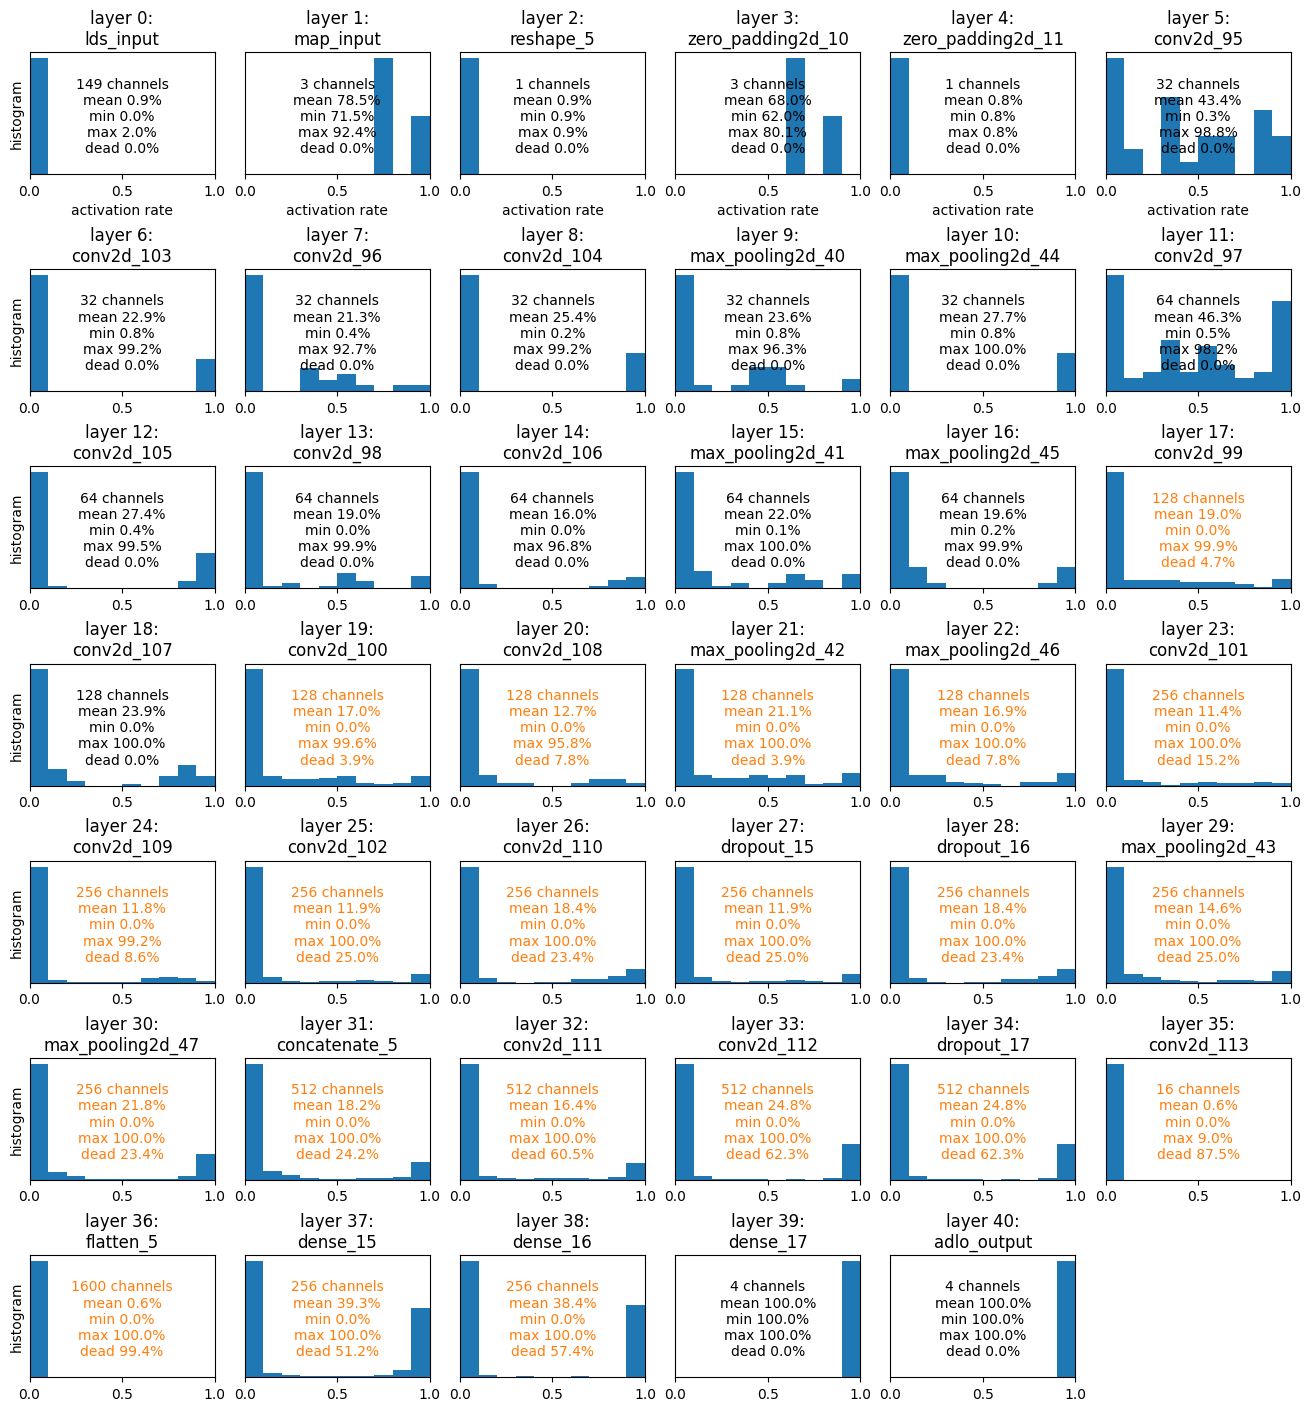

In [80]:
reload(toolkit)
toolkit.plot_channel_stats(layer_channel_activity, untrained_model)